In [1]:
import datetime
import os
import pprint

import numpy as np
from tianshou.data.buffer.vecbuf import VectorReplayBuffer, ReplayBuffer
from tianshou.env.venvs import SubprocVectorEnv
import torch
from torch.utils.tensorboard import SummaryWriter
from env.risky_pointmass import PointMass
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
task = "PointMass"
seed = 0
risk_type = "wang"
buffer_size = 1000000
hidden_sizes = [256, 256, 256]
actor_lr = 3e-4
critic_lr = 3e-4
gamma = 0.99
tau = 0.005
alpha = 0.02
auto_alpha = True
exploration = True
alpha_lr = 3e-4
start_timesteps = 10000
epoch = 100
step_per_epoch = 500
step_per_collect = 1
update_per_step = 1
n_step = 1
batch_size = 1024
training_num = 1
test_num = 10
logdir = "log"
device = "cuda:1"

In [3]:
distortion_param = -0.75
risk_penalty = 20
risk_prob = 0.95
env = PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob)

In [4]:
train_envs = SubprocVectorEnv([lambda: PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob) for _ in range(training_num)])
test_envs = SubprocVectorEnv([lambda: PointMass(risk_penalty=risk_penalty, risk_prob=risk_prob) for _ in range(test_num)])
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
max_action = env.action_space.high[0]
print("Observations shape:", state_shape)
print("Actions shape:", action_shape)
print("Action range:", np.min(env.action_space.low), np.max(env.action_space.high))

Observations shape: (2,)
Actions shape: (2,)
Action range: -0.05 0.05


In [13]:
# seed
np.random.seed(seed)
torch.manual_seed(seed)
# model
net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
actor = ActorProb(
    net_a,
    action_shape,
    device=device,
    unbounded=True,
    conditioned_sigma=True,
).to(device)
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

critic1 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
critic2 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

if auto_alpha:
    target_entropy = -np.prod(env.action_space.shape)
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
    alpha = (target_entropy, log_alpha, alpha_optim)

policy = DSACPolicy(
    actor,
    actor_optim,
    critic1,
    critic1_optim,
    critic2,
    critic2_optim,
    risk_type=risk_type,
    tau=tau,
    gamma=gamma,
    alpha=alpha,
    estimation_step=n_step,
    action_space=env.action_space,
    distortion_param=distortion_param,
    device=device,
)

# collector
buffer = VectorReplayBuffer(buffer_size, training_num)
train_collector = Collector(policy, train_envs, buffer, exploration_noise=exploration)
test_buffer = VectorReplayBuffer(1000*test_num, test_num)
test_collector = Collector(policy, test_envs, test_buffer)

In [14]:
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
algo_name = "dsac"
risk_ = ""
if risk_type in ["wang", "cvar"]:
    risk_ = risk_type + str(distortion_param)
log_name = os.path.join(task+f"_prob{risk_prob}"+f"_pen{risk_penalty}", algo_name, risk_, str(seed), now)
log_path = os.path.join(logdir, log_name)
print(f"log path: {log_path}")

# logger
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

log path: log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-175031


In [5]:
def save_best_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, "policy.pth"))

In [16]:
result = OffpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=batch_size,
    save_best_fn=save_best_fn,
    # test_fn=test_fn,
    logger=logger,
    update_per_step=update_per_step,
    test_in_train=False,
).run()
pprint.pprint(result)

Epoch #1: 501it [00:16, 29.86it/s, env_step=500, gradient_step=500, len=200, loss/actor=1.896, loss/critic1=0.020, loss/critic2=0.019, n/ep=0, n/st=1, rew=-70.77]                          


Epoch #1: test_reward: -69.776500 ± 11.348256, best_reward: -69.776500 ± 11.348256 in #1


Epoch #2: 501it [00:16, 29.87it/s, env_step=1000, gradient_step=1000, len=110, loss/actor=2.264, loss/critic1=0.028, loss/critic2=0.029, n/ep=0, n/st=1, rew=-17.77]                         


Epoch #2: test_reward: -70.708868 ± 20.782360, best_reward: -69.776500 ± 11.348256 in #1


Epoch #3: 501it [00:17, 29.45it/s, env_step=1500, gradient_step=1500, len=200, loss/actor=2.274, loss/critic1=0.019, loss/critic2=0.023, n/ep=0, n/st=1, rew=-55.57]                         


Epoch #3: test_reward: -97.204564 ± 106.542524, best_reward: -69.776500 ± 11.348256 in #1


Epoch #4: 501it [00:17, 29.16it/s, env_step=2000, gradient_step=2000, len=200, loss/actor=2.678, loss/critic1=0.032, loss/critic2=0.033, n/ep=0, n/st=1, rew=-179.78]                         


Epoch #4: test_reward: -38.062729 ± 10.685168, best_reward: -38.062729 ± 10.685168 in #4


Epoch #5: 501it [00:17, 29.41it/s, env_step=2500, gradient_step=2500, len=200, loss/actor=2.814, loss/critic1=0.026, loss/critic2=0.026, n/ep=0, n/st=1, rew=-40.19]                         


Epoch #5: test_reward: -61.387441 ± 24.984190, best_reward: -38.062729 ± 10.685168 in #4


Epoch #6: 501it [00:17, 29.44it/s, env_step=3000, gradient_step=3000, len=200, loss/actor=3.054, loss/critic1=0.018, loss/critic2=0.017, n/ep=0, n/st=1, rew=-54.36]                         


Epoch #6: test_reward: -46.318362 ± 9.110755, best_reward: -38.062729 ± 10.685168 in #4


Epoch #7: 501it [00:17, 29.31it/s, env_step=3500, gradient_step=3500, len=200, loss/actor=3.233, loss/critic1=0.013, loss/critic2=0.013, n/ep=0, n/st=1, rew=-30.24]                         


Epoch #7: test_reward: -115.091401 ± 205.496512, best_reward: -38.062729 ± 10.685168 in #4


Epoch #8: 501it [00:17, 29.42it/s, env_step=4000, gradient_step=4000, len=47, loss/actor=3.497, loss/critic1=0.018, loss/critic2=0.017, n/ep=0, n/st=1, rew=-37.12]                          


Epoch #8: test_reward: -40.258811 ± 31.831800, best_reward: -38.062729 ± 10.685168 in #4


Epoch #9: 501it [00:17, 29.26it/s, env_step=4500, gradient_step=4500, len=29, loss/actor=3.897, loss/critic1=0.034, loss/critic2=0.034, n/ep=0, n/st=1, rew=-7.35]                          


Epoch #9: test_reward: -40.975009 ± 27.908008, best_reward: -38.062729 ± 10.685168 in #4


Epoch #10: 501it [00:17, 29.29it/s, env_step=5000, gradient_step=5000, len=30, loss/actor=4.155, loss/critic1=0.056, loss/critic2=0.057, n/ep=0, n/st=1, rew=-5.12]                          


Epoch #10: test_reward: -36.350565 ± 23.212356, best_reward: -36.350565 ± 23.212356 in #10


Epoch #11: 501it [00:17, 29.26it/s, env_step=5500, gradient_step=5500, len=24, loss/actor=4.292, loss/critic1=0.091, loss/critic2=0.093, n/ep=0, n/st=1, rew=-9.60]                          


Epoch #11: test_reward: -46.576270 ± 50.352644, best_reward: -36.350565 ± 23.212356 in #10


Epoch #12: 501it [00:17, 29.25it/s, env_step=6000, gradient_step=6000, len=31, loss/actor=4.241, loss/critic1=0.132, loss/critic2=0.133, n/ep=0, n/st=1, rew=-17.72]                          


Epoch #12: test_reward: -51.416098 ± 24.703513, best_reward: -36.350565 ± 23.212356 in #10


Epoch #13: 501it [00:17, 29.20it/s, env_step=6500, gradient_step=6500, len=200, loss/actor=3.610, loss/critic1=0.178, loss/critic2=0.177, n/ep=0, n/st=1, rew=-89.19]                         


Epoch #13: test_reward: -48.454901 ± 20.124818, best_reward: -36.350565 ± 23.212356 in #10


Epoch #14: 501it [00:17, 29.21it/s, env_step=7000, gradient_step=7000, len=20, loss/actor=3.372, loss/critic1=0.201, loss/critic2=0.200, n/ep=0, n/st=1, rew=-7.44]                          


Epoch #14: test_reward: -15.693035 ± 17.280157, best_reward: -15.693035 ± 17.280157 in #14


Epoch #15: 501it [00:17, 29.13it/s, env_step=7500, gradient_step=7500, len=28, loss/actor=3.147, loss/critic1=0.223, loss/critic2=0.224, n/ep=0, n/st=1, rew=-15.27]                         


Epoch #15: test_reward: -8.975185 ± 15.303847, best_reward: -8.975185 ± 15.303847 in #15


Epoch #16: 501it [00:17, 29.17it/s, env_step=8000, gradient_step=8000, len=11, loss/actor=3.060, loss/critic1=0.219, loss/critic2=0.220, n/ep=0, n/st=1, rew=-1.70]                          


Epoch #16: test_reward: -19.476192 ± 26.387346, best_reward: -8.975185 ± 15.303847 in #15


Epoch #17: 501it [00:17, 29.07it/s, env_step=8500, gradient_step=8500, len=28, loss/actor=2.979, loss/critic1=0.209, loss/critic2=0.211, n/ep=0, n/st=1, rew=-16.21]                         


Epoch #17: test_reward: -12.548114 ± 16.795623, best_reward: -8.975185 ± 15.303847 in #15


Epoch #18: 501it [00:17, 29.13it/s, env_step=9000, gradient_step=9000, len=22, loss/actor=2.759, loss/critic1=0.177, loss/critic2=0.179, n/ep=0, n/st=1, rew=-30.03]                         


Epoch #18: test_reward: -15.532994 ± 21.087599, best_reward: -8.975185 ± 15.303847 in #15


Epoch #19: 501it [00:17, 28.92it/s, env_step=9500, gradient_step=9500, len=7, loss/actor=2.576, loss/critic1=0.158, loss/critic2=0.161, n/ep=0, n/st=1, rew=-0.40]                           


Epoch #19: test_reward: -7.842948 ± 8.373862, best_reward: -7.842948 ± 8.373862 in #19


Epoch #20: 501it [00:17, 28.77it/s, env_step=10000, gradient_step=10000, len=19, loss/actor=2.439, loss/critic1=0.156, loss/critic2=0.157, n/ep=0, n/st=1, rew=-28.27]                         


Epoch #20: test_reward: -8.018006 ± 10.334373, best_reward: -7.842948 ± 8.373862 in #19


Epoch #21: 501it [00:17, 28.84it/s, env_step=10500, gradient_step=10500, len=5, loss/actor=2.365, loss/critic1=0.164, loss/critic2=0.166, n/ep=0, n/st=1, rew=0.36]                            


Epoch #21: test_reward: -10.557292 ± 13.353103, best_reward: -7.842948 ± 8.373862 in #19


Epoch #22: 501it [00:17, 28.70it/s, env_step=11000, gradient_step=11000, len=15, loss/actor=2.341, loss/critic1=0.160, loss/critic2=0.161, n/ep=0, n/st=1, rew=-4.57]                          


Epoch #22: test_reward: -9.931293 ± 8.925823, best_reward: -7.842948 ± 8.373862 in #19


Epoch #23: 501it [00:17, 28.91it/s, env_step=11500, gradient_step=11500, len=1, loss/actor=2.284, loss/critic1=0.161, loss/critic2=0.160, n/ep=0, n/st=1, rew=0.89]                            


Epoch #23: test_reward: -13.838187 ± 21.526860, best_reward: -7.842948 ± 8.373862 in #19


Epoch #24: 501it [00:17, 28.92it/s, env_step=12000, gradient_step=12000, len=21, loss/actor=2.282, loss/critic1=0.165, loss/critic2=0.167, n/ep=0, n/st=1, rew=-8.73]                          


Epoch #24: test_reward: -8.886648 ± 6.652010, best_reward: -7.842948 ± 8.373862 in #19


Epoch #25: 501it [00:17, 28.90it/s, env_step=12500, gradient_step=12500, len=20, loss/actor=2.257, loss/critic1=0.148, loss/critic2=0.150, n/ep=1, n/st=1, rew=-8.14]                          


Epoch #25: test_reward: -8.693827 ± 10.346481, best_reward: -7.842948 ± 8.373862 in #19


Epoch #26: 501it [00:17, 29.07it/s, env_step=13000, gradient_step=13000, len=14, loss/actor=2.235, loss/critic1=0.154, loss/critic2=0.154, n/ep=0, n/st=1, rew=-3.96]                          


Epoch #26: test_reward: -10.373741 ± 11.222301, best_reward: -7.842948 ± 8.373862 in #19


Epoch #27: 501it [00:17, 29.06it/s, env_step=13500, gradient_step=13500, len=9, loss/actor=2.255, loss/critic1=0.150, loss/critic2=0.150, n/ep=0, n/st=1, rew=-0.83]                           


Epoch #27: test_reward: -16.213990 ± 18.081527, best_reward: -7.842948 ± 8.373862 in #19


Epoch #28: 501it [00:17, 28.88it/s, env_step=14000, gradient_step=14000, len=15, loss/actor=2.238, loss/critic1=0.150, loss/critic2=0.150, n/ep=0, n/st=1, rew=-4.02]                          


Epoch #28: test_reward: -6.368106 ± 4.723202, best_reward: -6.368106 ± 4.723202 in #28


Epoch #29: 501it [00:17, 28.84it/s, env_step=14500, gradient_step=14500, len=20, loss/actor=2.264, loss/critic1=0.161, loss/critic2=0.162, n/ep=0, n/st=1, rew=-29.59]                         


Epoch #29: test_reward: -15.071484 ± 13.488617, best_reward: -6.368106 ± 4.723202 in #28


Epoch #30: 501it [00:17, 28.96it/s, env_step=15000, gradient_step=15000, len=19, loss/actor=2.285, loss/critic1=0.174, loss/critic2=0.175, n/ep=0, n/st=1, rew=-7.76]                          


Epoch #30: test_reward: -3.365794 ± 2.879575, best_reward: -3.365794 ± 2.879575 in #30


Epoch #31: 501it [00:17, 28.98it/s, env_step=15500, gradient_step=15500, len=15, loss/actor=2.274, loss/critic1=0.178, loss/critic2=0.177, n/ep=0, n/st=1, rew=-4.90]                          


Epoch #31: test_reward: -7.172189 ± 4.417005, best_reward: -3.365794 ± 2.879575 in #30


Epoch #32: 501it [00:17, 29.09it/s, env_step=16000, gradient_step=16000, len=13, loss/actor=2.324, loss/critic1=0.184, loss/critic2=0.186, n/ep=1, n/st=1, rew=-3.15]                          


Epoch #32: test_reward: -10.356065 ± 20.969287, best_reward: -3.365794 ± 2.879575 in #30


Epoch #33: 501it [00:17, 29.30it/s, env_step=16500, gradient_step=16500, len=22, loss/actor=2.381, loss/critic1=0.194, loss/critic2=0.194, n/ep=0, n/st=1, rew=-51.83]                         


Epoch #33: test_reward: -6.912762 ± 8.351541, best_reward: -3.365794 ± 2.879575 in #30


Epoch #34: 501it [00:17, 29.36it/s, env_step=17000, gradient_step=17000, len=15, loss/actor=2.391, loss/critic1=0.202, loss/critic2=0.202, n/ep=0, n/st=1, rew=-4.58]                          


Epoch #34: test_reward: -5.366083 ± 10.390356, best_reward: -3.365794 ± 2.879575 in #30


Epoch #35: 501it [00:17, 29.12it/s, env_step=17500, gradient_step=17500, len=16, loss/actor=2.390, loss/critic1=0.210, loss/critic2=0.211, n/ep=0, n/st=1, rew=-5.51]                          


Epoch #35: test_reward: -6.633048 ± 8.397478, best_reward: -3.365794 ± 2.879575 in #30


Epoch #36: 501it [00:17, 29.20it/s, env_step=18000, gradient_step=18000, len=25, loss/actor=2.419, loss/critic1=0.213, loss/critic2=0.214, n/ep=0, n/st=1, rew=-14.86]                         


Epoch #36: test_reward: -5.931174 ± 7.823715, best_reward: -3.365794 ± 2.879575 in #30


Epoch #37: 501it [00:17, 29.27it/s, env_step=18500, gradient_step=18500, len=11, loss/actor=2.456, loss/critic1=0.217, loss/critic2=0.219, n/ep=0, n/st=1, rew=-2.53]                          


Epoch #37: test_reward: -12.212262 ± 15.307849, best_reward: -3.365794 ± 2.879575 in #30


Epoch #38: 501it [00:17, 29.36it/s, env_step=19000, gradient_step=19000, len=8, loss/actor=2.464, loss/critic1=0.224, loss/critic2=0.226, n/ep=0, n/st=1, rew=-0.72]                           


Epoch #38: test_reward: -9.128454 ± 8.825163, best_reward: -3.365794 ± 2.879575 in #30


Epoch #39: 501it [00:17, 29.33it/s, env_step=19500, gradient_step=19500, len=22, loss/actor=2.506, loss/critic1=0.234, loss/critic2=0.234, n/ep=0, n/st=1, rew=-10.60]                         


Epoch #39: test_reward: -17.633374 ± 25.792470, best_reward: -3.365794 ± 2.879575 in #30


Epoch #40: 501it [00:17, 29.36it/s, env_step=20000, gradient_step=20000, len=24, loss/actor=2.527, loss/critic1=0.231, loss/critic2=0.232, n/ep=0, n/st=1, rew=-35.18]                         


Epoch #40: test_reward: -16.894759 ± 22.291493, best_reward: -3.365794 ± 2.879575 in #30


Epoch #41: 501it [00:17, 29.38it/s, env_step=20500, gradient_step=20500, len=26, loss/actor=2.547, loss/critic1=0.238, loss/critic2=0.242, n/ep=0, n/st=1, rew=-35.17]                         


Epoch #41: test_reward: -12.211481 ± 14.416557, best_reward: -3.365794 ± 2.879575 in #30


Epoch #42: 501it [00:17, 29.23it/s, env_step=21000, gradient_step=21000, len=17, loss/actor=2.563, loss/critic1=0.242, loss/critic2=0.242, n/ep=1, n/st=1, rew=-5.38]                          


Epoch #42: test_reward: -7.642699 ± 9.324465, best_reward: -3.365794 ± 2.879575 in #30


Epoch #43: 501it [00:17, 29.08it/s, env_step=21500, gradient_step=21500, len=21, loss/actor=2.644, loss/critic1=0.252, loss/critic2=0.254, n/ep=0, n/st=1, rew=-11.15]                         


Epoch #43: test_reward: -9.066304 ± 13.884492, best_reward: -3.365794 ± 2.879575 in #30


Epoch #44: 501it [00:17, 29.26it/s, env_step=22000, gradient_step=22000, len=20, loss/actor=2.633, loss/critic1=0.251, loss/critic2=0.252, n/ep=0, n/st=1, rew=-9.46]                          


Epoch #44: test_reward: -7.402405 ± 7.389882, best_reward: -3.365794 ± 2.879575 in #30


Epoch #45: 501it [00:17, 29.23it/s, env_step=22500, gradient_step=22500, len=19, loss/actor=2.671, loss/critic1=0.255, loss/critic2=0.256, n/ep=0, n/st=1, rew=-8.83]                          


Epoch #45: test_reward: -8.120577 ± 8.700584, best_reward: -3.365794 ± 2.879575 in #30


Epoch #46: 501it [00:17, 29.29it/s, env_step=23000, gradient_step=23000, len=16, loss/actor=2.682, loss/critic1=0.264, loss/critic2=0.265, n/ep=0, n/st=1, rew=-6.12]                          


Epoch #46: test_reward: -9.528008 ± 10.133430, best_reward: -3.365794 ± 2.879575 in #30


Epoch #47: 501it [00:17, 29.40it/s, env_step=23500, gradient_step=23500, len=26, loss/actor=2.724, loss/critic1=0.269, loss/critic2=0.271, n/ep=0, n/st=1, rew=-36.21]                         


Epoch #47: test_reward: -7.189307 ± 9.686947, best_reward: -3.365794 ± 2.879575 in #30


Epoch #48: 501it [00:17, 29.40it/s, env_step=24000, gradient_step=24000, len=5, loss/actor=2.710, loss/critic1=0.265, loss/critic2=0.265, n/ep=0, n/st=1, rew=0.02]                            


Epoch #48: test_reward: -10.228356 ± 15.994924, best_reward: -3.365794 ± 2.879575 in #30


Epoch #49: 501it [00:17, 29.37it/s, env_step=24500, gradient_step=24500, len=6, loss/actor=2.676, loss/critic1=0.261, loss/critic2=0.262, n/ep=0, n/st=1, rew=-0.21]                           


Epoch #49: test_reward: -7.637305 ± 11.940518, best_reward: -3.365794 ± 2.879575 in #30


Epoch #50: 501it [00:17, 29.36it/s, env_step=25000, gradient_step=25000, len=26, loss/actor=2.734, loss/critic1=0.269, loss/critic2=0.271, n/ep=0, n/st=1, rew=-36.84]                         


Epoch #50: test_reward: -6.669706 ± 9.476635, best_reward: -3.365794 ± 2.879575 in #30


Epoch #51: 501it [00:17, 29.38it/s, env_step=25500, gradient_step=25500, len=7, loss/actor=2.758, loss/critic1=0.276, loss/critic2=0.276, n/ep=0, n/st=1, rew=-0.44]                           


Epoch #51: test_reward: -17.153809 ± 21.809515, best_reward: -3.365794 ± 2.879575 in #30


Epoch #52: 501it [00:17, 29.43it/s, env_step=26000, gradient_step=26000, len=9, loss/actor=2.767, loss/critic1=0.275, loss/critic2=0.275, n/ep=0, n/st=1, rew=-1.61]                           


Epoch #52: test_reward: -13.821806 ± 14.727906, best_reward: -3.365794 ± 2.879575 in #30


Epoch #53: 501it [00:17, 29.40it/s, env_step=26500, gradient_step=26500, len=10, loss/actor=2.722, loss/critic1=0.274, loss/critic2=0.274, n/ep=1, n/st=1, rew=-1.50]                          


Epoch #53: test_reward: -11.390580 ± 9.079481, best_reward: -3.365794 ± 2.879575 in #30


Epoch #54: 501it [00:17, 29.37it/s, env_step=27000, gradient_step=27000, len=3, loss/actor=2.757, loss/critic1=0.274, loss/critic2=0.273, n/ep=0, n/st=1, rew=0.64]                            


Epoch #54: test_reward: -10.930364 ± 16.047732, best_reward: -3.365794 ± 2.879575 in #30


Epoch #55: 501it [00:17, 29.35it/s, env_step=27500, gradient_step=27500, len=3, loss/actor=2.742, loss/critic1=0.274, loss/critic2=0.274, n/ep=0, n/st=1, rew=0.64]                            


Epoch #55: test_reward: -6.860174 ± 8.641711, best_reward: -3.365794 ± 2.879575 in #30


Epoch #56: 501it [00:17, 29.36it/s, env_step=28000, gradient_step=28000, len=18, loss/actor=2.759, loss/critic1=0.279, loss/critic2=0.278, n/ep=0, n/st=1, rew=-7.58]                          


Epoch #56: test_reward: -5.318544 ± 4.548434, best_reward: -3.365794 ± 2.879575 in #30


Epoch #57: 501it [00:17, 29.37it/s, env_step=28500, gradient_step=28500, len=5, loss/actor=2.739, loss/critic1=0.274, loss/critic2=0.274, n/ep=0, n/st=1, rew=0.07]                            


Epoch #57: test_reward: -9.134035 ± 12.383509, best_reward: -3.365794 ± 2.879575 in #30


Epoch #58: 501it [00:17, 29.33it/s, env_step=29000, gradient_step=29000, len=21, loss/actor=2.771, loss/critic1=0.278, loss/critic2=0.280, n/ep=0, n/st=1, rew=-8.99]                          


Epoch #58: test_reward: -15.649018 ± 14.744548, best_reward: -3.365794 ± 2.879575 in #30


Epoch #59: 501it [00:17, 29.34it/s, env_step=29500, gradient_step=29500, len=19, loss/actor=2.780, loss/critic1=0.278, loss/critic2=0.279, n/ep=0, n/st=1, rew=-8.30]                          


Epoch #59: test_reward: -17.319339 ± 23.845015, best_reward: -3.365794 ± 2.879575 in #30


Epoch #60: 501it [00:17, 29.27it/s, env_step=30000, gradient_step=30000, len=21, loss/actor=2.754, loss/critic1=0.278, loss/critic2=0.279, n/ep=0, n/st=1, rew=-30.07]                         


Epoch #60: test_reward: -3.098191 ± 4.383371, best_reward: -3.098191 ± 4.383371 in #60


Epoch #61: 501it [00:17, 29.28it/s, env_step=30500, gradient_step=30500, len=17, loss/actor=2.757, loss/critic1=0.278, loss/critic2=0.278, n/ep=0, n/st=1, rew=-6.97]                          


Epoch #61: test_reward: -8.776252 ± 9.188974, best_reward: -3.098191 ± 4.383371 in #60


Epoch #62: 501it [00:17, 28.97it/s, env_step=31000, gradient_step=31000, len=18, loss/actor=2.796, loss/critic1=0.283, loss/critic2=0.283, n/ep=0, n/st=1, rew=-8.10]                          


Epoch #62: test_reward: -12.127519 ± 14.591501, best_reward: -3.098191 ± 4.383371 in #60


Epoch #63: 501it [00:17, 28.85it/s, env_step=31500, gradient_step=31500, len=15, loss/actor=2.786, loss/critic1=0.280, loss/critic2=0.282, n/ep=0, n/st=1, rew=-5.32]                          


Epoch #63: test_reward: -13.160367 ± 15.363058, best_reward: -3.098191 ± 4.383371 in #60


Epoch #64: 501it [00:17, 28.93it/s, env_step=32000, gradient_step=32000, len=4, loss/actor=2.787, loss/critic1=0.278, loss/critic2=0.279, n/ep=0, n/st=1, rew=0.44]                            


Epoch #64: test_reward: -7.648046 ± 4.521120, best_reward: -3.098191 ± 4.383371 in #60


Epoch #65: 501it [00:17, 28.89it/s, env_step=32500, gradient_step=32500, len=14, loss/actor=2.792, loss/critic1=0.276, loss/critic2=0.276, n/ep=0, n/st=1, rew=-4.31]                          


Epoch #65: test_reward: -12.267022 ± 14.187226, best_reward: -3.098191 ± 4.383371 in #60


Epoch #66: 501it [00:17, 28.77it/s, env_step=33000, gradient_step=33000, len=17, loss/actor=2.788, loss/critic1=0.280, loss/critic2=0.281, n/ep=0, n/st=1, rew=-6.89]                          


Epoch #66: test_reward: -12.511561 ± 21.648487, best_reward: -3.098191 ± 4.383371 in #60


Epoch #67: 501it [00:17, 28.95it/s, env_step=33500, gradient_step=33500, len=5, loss/actor=2.811, loss/critic1=0.284, loss/critic2=0.283, n/ep=0, n/st=1, rew=-0.06]                           


Epoch #67: test_reward: -4.637718 ± 6.020138, best_reward: -3.098191 ± 4.383371 in #60


Epoch #68: 501it [00:17, 29.23it/s, env_step=34000, gradient_step=34000, len=2, loss/actor=2.790, loss/critic1=0.279, loss/critic2=0.280, n/ep=0, n/st=1, rew=0.74]                            


Epoch #68: test_reward: -12.269373 ± 21.750713, best_reward: -3.098191 ± 4.383371 in #60


Epoch #69: 501it [00:17, 29.27it/s, env_step=34500, gradient_step=34500, len=7, loss/actor=2.835, loss/critic1=0.290, loss/critic2=0.292, n/ep=0, n/st=1, rew=-0.45]                           


Epoch #69: test_reward: -10.533902 ± 9.990979, best_reward: -3.098191 ± 4.383371 in #60


Epoch #70: 501it [00:17, 29.32it/s, env_step=35000, gradient_step=35000, len=4, loss/actor=2.837, loss/critic1=0.290, loss/critic2=0.290, n/ep=0, n/st=1, rew=0.40]                            


Epoch #70: test_reward: -6.975229 ± 8.491690, best_reward: -3.098191 ± 4.383371 in #60


Epoch #71: 501it [00:17, 29.35it/s, env_step=35500, gradient_step=35500, len=20, loss/actor=2.852, loss/critic1=0.293, loss/critic2=0.293, n/ep=0, n/st=1, rew=-29.52]                         


Epoch #71: test_reward: -10.143932 ± 5.128145, best_reward: -3.098191 ± 4.383371 in #60


Epoch #72: 501it [00:17, 29.31it/s, env_step=36000, gradient_step=36000, len=11, loss/actor=2.877, loss/critic1=0.302, loss/critic2=0.302, n/ep=0, n/st=1, rew=-2.20]                          


Epoch #72: test_reward: -6.941832 ± 9.345757, best_reward: -3.098191 ± 4.383371 in #60


Epoch #73: 501it [00:17, 29.30it/s, env_step=36500, gradient_step=36500, len=13, loss/actor=2.838, loss/critic1=0.299, loss/critic2=0.301, n/ep=0, n/st=1, rew=-4.03]                          


Epoch #73: test_reward: -8.798351 ± 8.433746, best_reward: -3.098191 ± 4.383371 in #60


Epoch #74: 501it [00:17, 29.28it/s, env_step=37000, gradient_step=37000, len=7, loss/actor=2.868, loss/critic1=0.300, loss/critic2=0.300, n/ep=0, n/st=1, rew=-0.53]                           


Epoch #74: test_reward: -6.334770 ± 9.939410, best_reward: -3.098191 ± 4.383371 in #60


Epoch #75: 501it [00:17, 29.24it/s, env_step=37500, gradient_step=37500, len=20, loss/actor=2.865, loss/critic1=0.303, loss/critic2=0.303, n/ep=0, n/st=1, rew=-9.02]                          


Epoch #75: test_reward: -7.336965 ± 15.680217, best_reward: -3.098191 ± 4.383371 in #60


Epoch #76: 501it [00:17, 29.23it/s, env_step=38000, gradient_step=38000, len=19, loss/actor=2.908, loss/critic1=0.311, loss/critic2=0.311, n/ep=0, n/st=1, rew=-69.36]                         


Epoch #76: test_reward: -6.418662 ± 4.898480, best_reward: -3.098191 ± 4.383371 in #60


Epoch #77: 501it [00:17, 29.37it/s, env_step=38500, gradient_step=38500, len=22, loss/actor=2.902, loss/critic1=0.314, loss/critic2=0.313, n/ep=1, n/st=1, rew=-12.08]                         


Epoch #77: test_reward: -12.676602 ± 7.911760, best_reward: -3.098191 ± 4.383371 in #60


Epoch #78: 501it [00:17, 29.32it/s, env_step=39000, gradient_step=39000, len=13, loss/actor=2.907, loss/critic1=0.314, loss/critic2=0.314, n/ep=0, n/st=1, rew=-3.77]                          


Epoch #78: test_reward: -4.898506 ± 3.606047, best_reward: -3.098191 ± 4.383371 in #60


Epoch #79: 501it [00:17, 29.33it/s, env_step=39500, gradient_step=39500, len=20, loss/actor=2.911, loss/critic1=0.312, loss/critic2=0.311, n/ep=0, n/st=1, rew=-9.84]                          


Epoch #79: test_reward: -9.922308 ± 9.130052, best_reward: -3.098191 ± 4.383371 in #60


Epoch #80: 501it [00:17, 29.34it/s, env_step=40000, gradient_step=40000, len=8, loss/actor=2.907, loss/critic1=0.309, loss/critic2=0.309, n/ep=0, n/st=1, rew=-0.94]                           


Epoch #80: test_reward: -10.107005 ± 8.943784, best_reward: -3.098191 ± 4.383371 in #60


Epoch #81: 501it [00:17, 29.32it/s, env_step=40500, gradient_step=40500, len=12, loss/actor=2.884, loss/critic1=0.309, loss/critic2=0.308, n/ep=0, n/st=1, rew=-3.13]                          


Epoch #81: test_reward: -4.817939 ± 3.954642, best_reward: -3.098191 ± 4.383371 in #60


Epoch #82: 501it [00:17, 29.31it/s, env_step=41000, gradient_step=41000, len=6, loss/actor=2.907, loss/critic1=0.312, loss/critic2=0.311, n/ep=0, n/st=1, rew=-0.23]                           


Epoch #82: test_reward: -7.981093 ± 5.089347, best_reward: -3.098191 ± 4.383371 in #60


Epoch #83: 501it [00:17, 28.75it/s, env_step=41500, gradient_step=41500, len=6, loss/actor=2.864, loss/critic1=0.302, loss/critic2=0.301, n/ep=0, n/st=1, rew=-0.11]                           


Epoch #83: test_reward: -8.814019 ± 10.197700, best_reward: -3.098191 ± 4.383371 in #60


Epoch #84: 501it [00:17, 29.02it/s, env_step=42000, gradient_step=42000, len=5, loss/actor=2.897, loss/critic1=0.312, loss/critic2=0.312, n/ep=0, n/st=1, rew=0.03]                            


Epoch #84: test_reward: -10.419890 ± 10.782995, best_reward: -3.098191 ± 4.383371 in #60


Epoch #85: 501it [00:17, 28.81it/s, env_step=42500, gradient_step=42500, len=22, loss/actor=2.892, loss/critic1=0.315, loss/critic2=0.314, n/ep=0, n/st=1, rew=-12.77]                         


Epoch #85: test_reward: -12.712693 ± 21.467217, best_reward: -3.098191 ± 4.383371 in #60


Epoch #86: 501it [00:17, 29.03it/s, env_step=43000, gradient_step=43000, len=13, loss/actor=2.912, loss/critic1=0.322, loss/critic2=0.322, n/ep=0, n/st=1, rew=-3.71]                          


Epoch #86: test_reward: -9.947647 ± 7.986222, best_reward: -3.098191 ± 4.383371 in #60


Epoch #87: 501it [00:17, 28.96it/s, env_step=43500, gradient_step=43500, len=25, loss/actor=2.902, loss/critic1=0.315, loss/critic2=0.314, n/ep=0, n/st=1, rew=-15.31]                         


Epoch #87: test_reward: -10.741262 ± 8.884414, best_reward: -3.098191 ± 4.383371 in #60


Epoch #88: 501it [00:17, 28.70it/s, env_step=44000, gradient_step=44000, len=6, loss/actor=2.946, loss/critic1=0.319, loss/critic2=0.318, n/ep=0, n/st=1, rew=-0.25]                           


Epoch #88: test_reward: -9.063309 ± 8.998236, best_reward: -3.098191 ± 4.383371 in #60


Epoch #89: 501it [00:17, 29.34it/s, env_step=44500, gradient_step=44500, len=19, loss/actor=2.925, loss/critic1=0.317, loss/critic2=0.317, n/ep=0, n/st=1, rew=-48.83]                         


Epoch #89: test_reward: -12.076225 ± 11.847021, best_reward: -3.098191 ± 4.383371 in #60


Epoch #90: 501it [00:17, 28.86it/s, env_step=45000, gradient_step=45000, len=6, loss/actor=2.924, loss/critic1=0.310, loss/critic2=0.309, n/ep=0, n/st=1, rew=-0.06]                           


Epoch #90: test_reward: -4.922043 ± 3.397859, best_reward: -3.098191 ± 4.383371 in #60


Epoch #91: 501it [00:17, 28.79it/s, env_step=45500, gradient_step=45500, len=20, loss/actor=2.930, loss/critic1=0.316, loss/critic2=0.315, n/ep=0, n/st=1, rew=-30.56]                         


Epoch #91: test_reward: -15.781435 ± 21.301533, best_reward: -3.098191 ± 4.383371 in #60


Epoch #92: 501it [00:17, 28.96it/s, env_step=46000, gradient_step=46000, len=19, loss/actor=2.927, loss/critic1=0.317, loss/critic2=0.315, n/ep=0, n/st=1, rew=-8.21]                          


Epoch #92: test_reward: -9.602475 ± 14.623346, best_reward: -3.098191 ± 4.383371 in #60


Epoch #93: 501it [00:17, 28.93it/s, env_step=46500, gradient_step=46500, len=17, loss/actor=2.925, loss/critic1=0.313, loss/critic2=0.313, n/ep=0, n/st=1, rew=-67.38]                         


Epoch #93: test_reward: -14.926788 ± 16.279809, best_reward: -3.098191 ± 4.383371 in #60


Epoch #94: 501it [00:17, 29.07it/s, env_step=47000, gradient_step=47000, len=16, loss/actor=2.908, loss/critic1=0.308, loss/critic2=0.307, n/ep=0, n/st=1, rew=-5.64]                          


Epoch #94: test_reward: -8.574952 ± 5.027802, best_reward: -3.098191 ± 4.383371 in #60


Epoch #95: 501it [00:17, 29.16it/s, env_step=47500, gradient_step=47500, len=13, loss/actor=2.950, loss/critic1=0.315, loss/critic2=0.315, n/ep=1, n/st=1, rew=-3.62]                          


Epoch #95: test_reward: -4.421582 ± 4.790369, best_reward: -3.098191 ± 4.383371 in #60


Epoch #96: 501it [00:17, 29.13it/s, env_step=48000, gradient_step=48000, len=25, loss/actor=2.910, loss/critic1=0.310, loss/critic2=0.309, n/ep=0, n/st=1, rew=-54.94]                         


Epoch #96: test_reward: -10.814622 ± 10.999236, best_reward: -3.098191 ± 4.383371 in #60


Epoch #97: 501it [00:17, 29.17it/s, env_step=48500, gradient_step=48500, len=18, loss/actor=2.913, loss/critic1=0.313, loss/critic2=0.312, n/ep=0, n/st=1, rew=-47.60]                         


Epoch #97: test_reward: -7.088922 ± 8.388520, best_reward: -3.098191 ± 4.383371 in #60


Epoch #98: 501it [00:17, 29.19it/s, env_step=49000, gradient_step=49000, len=14, loss/actor=2.922, loss/critic1=0.322, loss/critic2=0.322, n/ep=0, n/st=1, rew=-4.27]                          


Epoch #98: test_reward: -6.654879 ± 8.062100, best_reward: -3.098191 ± 4.383371 in #60


Epoch #99: 501it [00:17, 29.15it/s, env_step=49500, gradient_step=49500, len=20, loss/actor=2.935, loss/critic1=0.321, loss/critic2=0.322, n/ep=0, n/st=1, rew=-9.96]                          


Epoch #99: test_reward: -4.504937 ± 5.657529, best_reward: -3.098191 ± 4.383371 in #60


Epoch #100: 501it [00:17, 29.10it/s, env_step=50000, gradient_step=50000, len=25, loss/actor=2.923, loss/critic1=0.321, loss/critic2=0.319, n/ep=0, n/st=1, rew=-35.42]                         


Epoch #100: test_reward: -14.938271 ± 16.316254, best_reward: -3.098191 ± 4.383371 in #60
{'best_result': '-3.10 ± 4.38',
 'best_reward': -3.0981909069658187,
 'duration': '1728.92s',
 'test_episode': 1010,
 'test_speed': '3434.62 step/s',
 'test_step': 37811,
 'test_time': '11.01s',
 'train_episode': 2999,
 'train_speed': '29.11 step/s',
 'train_step': 50000,
 'train_time/collector': '90.09s',
 'train_time/model': '1627.83s'}


In [20]:
# save the buffer
buffer.save_hdf5(os.path.join(log_path, "buffer.hdf5"))

In [6]:
def get_init_states(n=50, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x_grid = np.linspace(0.4, 1, 101)
    y_grid = np.linspace(0.4, 1, 101)
    init_states = np.stack([(x, y) for x in x_grid for y in y_grid])
    init_states = np.array([(x, y) for x, y in init_states if np.linalg.norm(np.array((x,y))-env.center) > env.r])
    init_states = init_states[np.random.choice(len(init_states), n)]
    return init_states   

def plot_trajectories(policy):
    policy.eval()
    init_states = get_init_states()
    trajectories = []
    for state in init_states:
        obs, info = env.reset(init_state=state)
        done = False
        cum_reward = 0
        actions = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated 
        trajectories.append(env.trajectory)

    # Create a figure for plotting
    plt.figure(figsize=(10, 10))

    # Plot the risk area
    circle = plt.Circle((0.5, 0.5), 0.3, color='red', alpha=0.3)
    plt.gca().add_patch(circle)

    # Plot the goal
    plt.scatter(*env.goal, color='green', marker='o', s=100, label='Goal')

    # Plot the start states
    plt.scatter(*zip(*init_states), color='blue', marker='o', s=10, label='Start States')

    # Plot the trajectories
    for traj in trajectories:
        plt.plot(*zip(*traj), color='gray', linewidth=1, alpha=0.3)

    plt.legend()
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Trajectories from Start States to Goal')
    plt.show()      

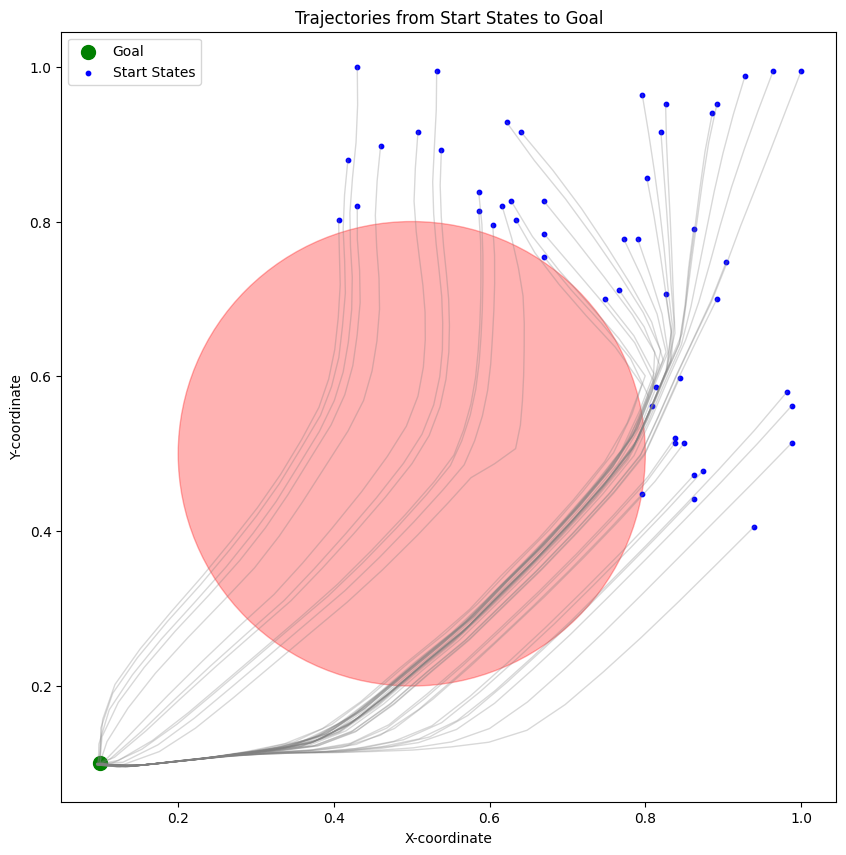

In [19]:
plot_trajectories(policy)

In [57]:
n_samples = 100
x_grid = np.linspace(0, 1, 101)
y_grid = np.linspace(0, 1, 101)
z_values = np.zeros((101, 101))
for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        env.state = np.array((x,y))
        if not env.is_safe():
            z = 0
            for _ in range(n_samples):
                reward, _ = env.get_reward()
                z += reward
            z_values[i, j] = z/n_samples
        else:
            reward, _ = env.get_reward()
            z_values[i, j] = reward

In [58]:
# Create a 2D contour plot
fig = go.Figure(data=[go.Contour(z=z_values, x=x_grid, y=y_grid)])

# Customize the layout
fig.update_layout(title='Rewards', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

# Show the plot
fig.show()

In [7]:
def load_policy(path, distortion_param=distortion_param, alpha=alpha):
    net_a = Net(state_shape, hidden_sizes=hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

    critic1 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=critic_lr)
    critic2 = QuantileMlp(hidden_sizes=hidden_sizes, input_size=state_shape[0] + action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=critic_lr)

    if auto_alpha:
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.tensor([np.log(0.02)], requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
        alpha = (target_entropy, log_alpha, alpha_optim)

    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type=risk_type,
        tau=tau,
        gamma=gamma,
        alpha=alpha,
        estimation_step=n_step,
        action_space=env.action_space,
        distortion_param=distortion_param,
        device=device,
    )
    policy.load_state_dict(torch.load(path, map_location=device))
    print("Loaded agent from: ", path)
    return policy

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang0.75/0/240116-114339/policy.pth


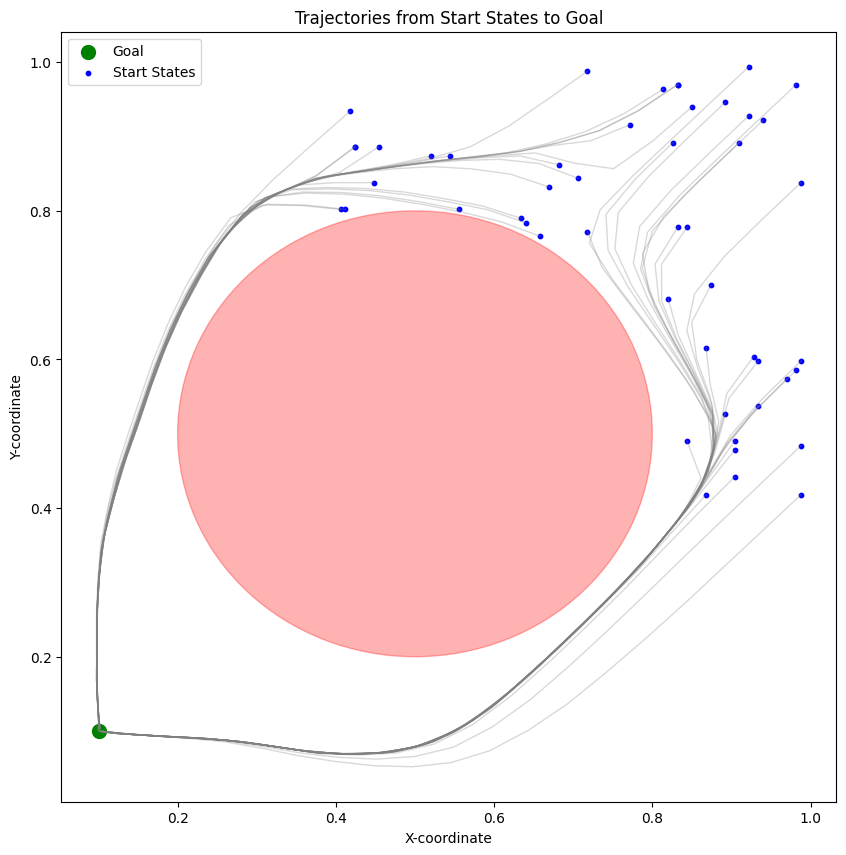

In [8]:
safe_policy_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang0.75/0/240116-114339/policy.pth"
safe_policy = load_policy(safe_policy_path)
plot_trajectories(safe_policy)

Loaded agent from:  /data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-111416/policy.pth


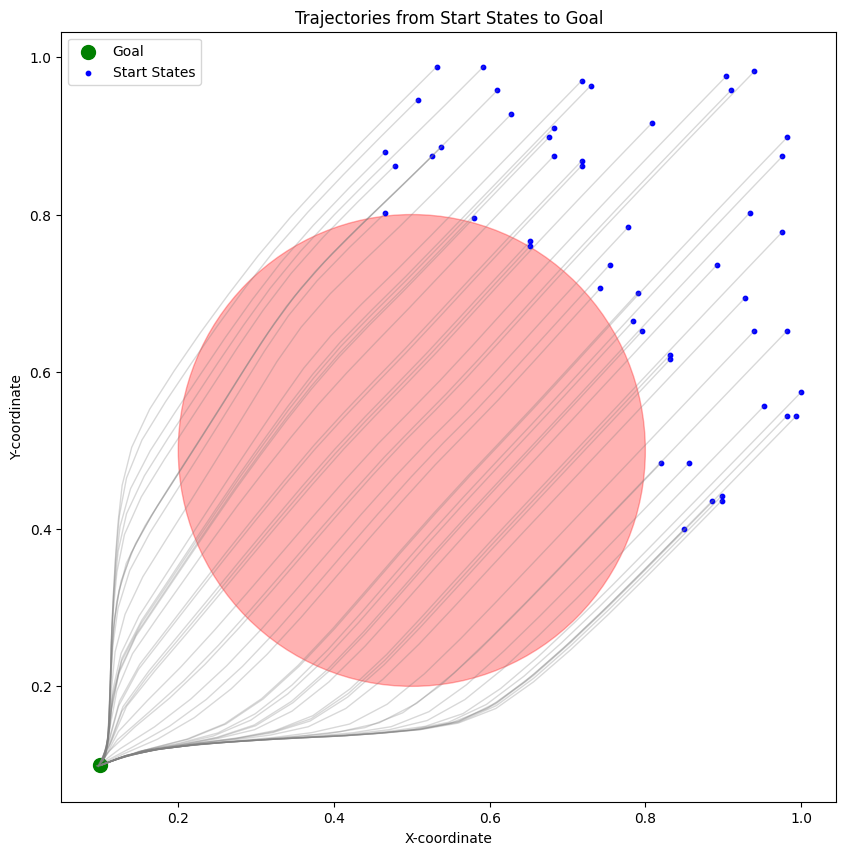

In [26]:
risky_policy_path = "/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-111416/policy.pth"
risky_policy =  load_policy(risky_policy_path, distortion_param=0.75)
plot_trajectories(risky_policy)

In [40]:
def get_qvalues(policy):
    policy.eval()
    x_grid = np.linspace(0, 1, 21)
    y_grid = np.linspace(0, 1, 21)
    init_states = np.array([(i, j) for i in x_grid for j in y_grid])
    qs = []
    for state in init_states:
        obs, info = env.reset(init_state=state)
        batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(dtype=torch.float32, device=device), info=info)
        with torch.no_grad():
            result = policy(batch)
            q_values = policy.critic1(batch.obs, result.act).cpu().numpy()
        qs.append(q_values)
    return np.array(qs).squeeze()

In [41]:
risky_qvalues = get_qvalues(risky_policy)

In [42]:
safe_qvalues = get_qvalues(safe_policy)

In [43]:
list(zip(risky_qvalues[:, 0], safe_qvalues[:, 0]))

[(0.06431035, -0.3206648),
 (0.25719804, -0.020501308),
 (0.37674385, 0.12996031),
 (0.5822897, 0.17448236),
 (0.3533439, 0.13233565),
 (0.08074261, 0.018535614),
 (-0.1860764, -0.25335395),
 (-0.5681172, -0.5627565),
 (-1.0900084, -0.98695236),
 (-1.5353981, -1.4432404),
 (-2.0068822, -1.9403744),
 (-2.6235566, -2.5052817),
 (-3.3597314, -3.170762),
 (-3.8638458, -3.7867718),
 (-4.61684, -4.600036),
 (-5.417799, -5.120871),
 (-6.3548365, -6.0331497),
 (-7.3019905, -6.9975114),
 (-8.352134, -7.962015),
 (-9.193067, -8.828004),
 (-10.257787, -9.588942),
 (0.21689229, -0.2204625),
 (0.3803218, 0.35697603),
 (0.6556801, 0.5272032),
 (0.63416827, 0.4482429),
 (0.36379617, 0.37679505),
 (0.119202025, 0.14941923),
 (-0.19822277, -0.15648657),
 (-0.54679024, -0.47554642),
 (-0.97089636, -0.9409368),
 (-1.3900607, -1.3798201),
 (-1.9886959, -1.88315),
 (-2.4920404, -2.5708025),
 (-3.2600522, -3.156761),
 (-3.840834, -3.6907487),
 (-5.1330166, -4.4467316),
 (-5.4973693, -5.2036314),
 (-6.32041,

In [27]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space):
        super().__init__(action_space=action_space, action_scaling=True)
        self.base_policy = base_policy
        self.expert_policy = expert_policy

    def forward(self, batch: RolloutBatchProtocol, state=None, **kwargs):
        self.base_policy.eval()
        self.expert_policy.eval()
        batch = to_torch(batch, dtype=torch.float32, device=device)
        with torch.no_grad():
            expert_result = self.expert_policy(batch)
            base_result = self.base_policy(batch)
            expert_qvalues1 = self.expert_policy.critic1(batch.obs, expert_result.act)
            expert_qvalues2 = self.expert_policy.critic2(batch.obs, expert_result.act)
            expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
            base_qvalues1 = self.base_policy.critic1(batch.obs, base_result.act)
            base_qvalues2 = self.base_policy.critic2(batch.obs, base_result.act)
            base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)
        cede_ctrl = base_qvalues[:, 0] < expert_qvalues[:, 0]
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, expert_result.act, base_result.act)
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        # cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        # batch = batch[~cede_ctrl]
        # info = {}
        # if len(batch) > 0:
        #     info = self.base_policy.learn(batch)
        info = self.base_policy.learn(batch)
        return info

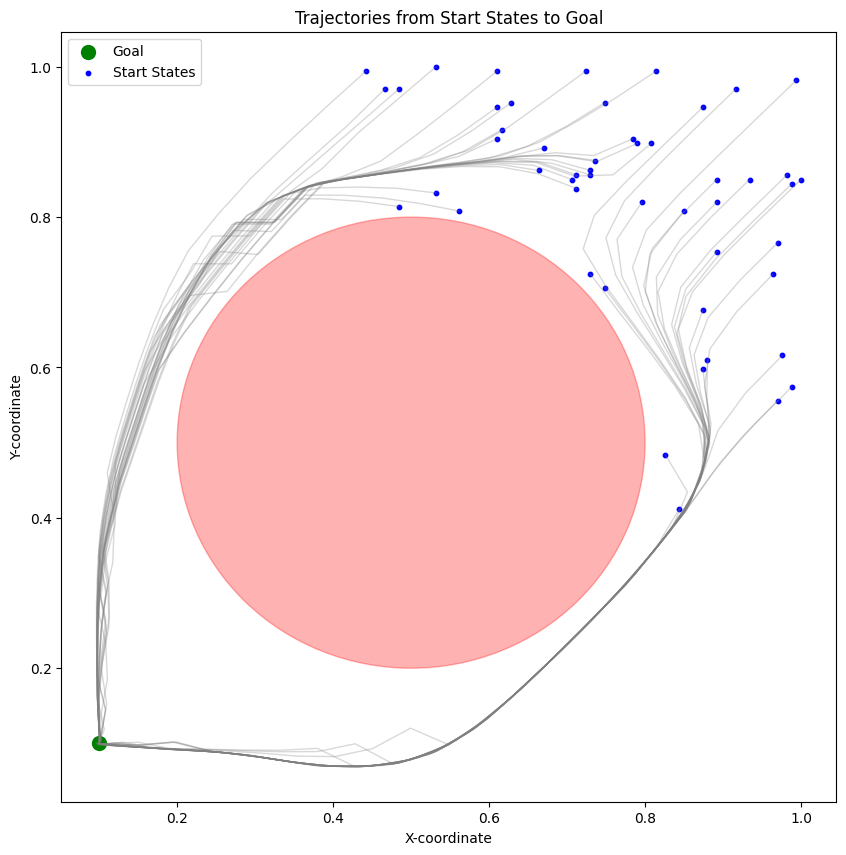

In [28]:
mixed_policy = MixedPolicy(risky_policy, safe_policy, env.action_space)
plot_trajectories(mixed_policy)

In [16]:
def get_returns(policy, n=50, rnd=True, return_cede_ctrl=False):
    policy.eval()
    returns = []
    cede_ctrl = []
    for _ in range(n):
        obs, info = env.reset(init_state=np.array([0.95, 0.95])+(np.random.uniform(-0.05, 0.05, 2)*float(rnd)))
        done = False
        cum_reward = 0
        actions = []
        if return_cede_ctrl:
            cctrl_ep = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            if return_cede_ctrl:
                cctrl_ep.append(result.policy.cede_ctrl.cpu().squeeze().numpy())
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated
        returns.append(cum_reward)
        if return_cede_ctrl:
            cede_ctrl.append(np.array(cctrl_ep).mean())
    if return_cede_ctrl:
        return np.array(returns),  np.array(cede_ctrl).mean()
    return np.array(returns), _

In [17]:
safe_returns, _ = get_returns(safe_policy)

In [18]:
risky_returns, _ = get_returns(risky_policy)

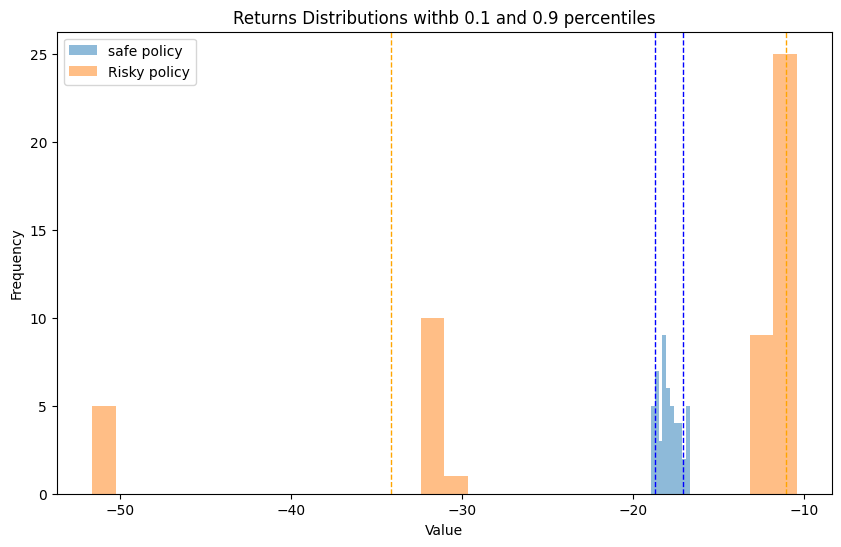

In [19]:
percentile_10_safe = np.percentile(safe_returns, 10)
percentile_90_safe = np.percentile(safe_returns, 90)
percentile_10_risky = np.percentile(risky_returns, 10)
percentile_90_risky = np.percentile(risky_returns, 90)

plt.figure(figsize=(10, 6))
plt.hist(safe_returns, bins=10, alpha=0.5, label='safe policy')
plt.hist(risky_returns, bins=30, alpha=0.5, label='Risky policy')
plt.axvline(percentile_10_safe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_safe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(percentile_10_risky, color='orange', linestyle='dashed', linewidth=1)
plt.axvline(percentile_90_risky, color='orange', linestyle='dashed', linewidth=1)

# Adding titles and labels
plt.title('Returns Distributions withb 0.1 and 0.9 percentiles')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [29]:
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
algo_name = "mixed"
log_name = os.path.join(task, algo_name, str(seed), now)
log_path = os.path.join(logdir, log_name)
print(f"log path: {log_path}")

# logger
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

log path: log/PointMass/mixed/0/240124-140153


In [30]:
def test_fn(num_epoch: int, step_idx: int):
    returns, cede_ctrl = get_returns(mixed_policy, 50, False, True)
    percentile_10 = np.percentile(returns, 10)
    print(percentile_10, cede_ctrl)

def save_best_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, "policy.pth"))

In [31]:
buffer = VectorReplayBuffer.load_hdf5("/data/user/R901105/dev/my_fork/tianshou/log/PointMass_prob0.95_pen20/dsac/wang-0.75/0/240116-111416/buffer.hdf5")
train_collector = Collector(mixed_policy, train_envs, buffer)
test_buffer = VectorReplayBuffer(1000*test_num, test_num)
test_collector = Collector(mixed_policy, test_envs, test_buffer)

In [32]:
result = OffpolicyTrainer(
    policy=mixed_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=1024,
    save_best_fn=save_best_fn,
    test_fn=test_fn,
    logger=logger,
    update_per_step=update_per_step,
    test_in_train=False,
).run()
pprint.pprint(result)

-17.758296242059874 0.9659259259259259


Epoch #1: 501it [00:18, 26.83it/s, alpha=0.017, env_step=500, gradient_step=500, len=3, loss/actor=2.559, loss/alpha=-20.178, loss/critic1=0.114, loss/critic2=0.114, n/ep=0, n/st=1, rew=0.64]                            


-17.91681089830277 0.5892857142857143
Epoch #1: test_reward: -5.668351 ± 5.072854, best_reward: -5.668351 ± 5.072854 in #1


Epoch #2: 501it [00:18, 26.60it/s, alpha=0.015, env_step=1000, gradient_step=1000, len=18, loss/actor=2.387, loss/alpha=-21.124, loss/critic1=0.093, loss/critic2=0.093, n/ep=0, n/st=1, rew=-7.40]                         


-17.93005094016575 0.5378571428571428
Epoch #2: test_reward: -8.032625 ± 5.330252, best_reward: -5.668351 ± 5.072854 in #1


Epoch #3: 501it [00:20, 24.97it/s, alpha=0.013, env_step=1500, gradient_step=1500, len=16, loss/actor=2.338, loss/alpha=-21.472, loss/critic1=0.093, loss/critic2=0.093, n/ep=0, n/st=1, rew=-6.02]                          


-17.95078473963541 0.5274876847290639
Epoch #3: test_reward: -6.556106 ± 5.583357, best_reward: -5.668351 ± 5.072854 in #1


Epoch #4: 501it [00:19, 25.89it/s, alpha=0.011, env_step=2000, gradient_step=2000, len=24, loss/actor=2.218, loss/alpha=-21.666, loss/critic1=0.085, loss/critic2=0.085, n/ep=0, n/st=1, rew=-13.40]                         


-18.053613804202435 0.4535714285714286
Epoch #4: test_reward: -4.661843 ± 4.595451, best_reward: -4.661843 ± 4.595451 in #4


Epoch #5: 501it [00:19, 26.20it/s, alpha=0.009, env_step=2500, gradient_step=2500, len=23, loss/actor=2.167, loss/alpha=-20.880, loss/critic1=0.082, loss/critic2=0.082, n/ep=0, n/st=1, rew=-12.52]                         


-18.049348656811826 0.46039682539682536
Epoch #5: test_reward: -8.601508 ± 5.594522, best_reward: -4.661843 ± 4.595451 in #4


Epoch #6: 501it [00:19, 26.16it/s, alpha=0.008, env_step=3000, gradient_step=3000, len=7, loss/actor=2.079, loss/alpha=-21.715, loss/critic1=0.075, loss/critic2=0.075, n/ep=1, n/st=1, rew=-0.49]                           


-17.912647599258932 0.32370370370370366
Epoch #6: test_reward: -4.170804 ± 4.785563, best_reward: -4.170804 ± 4.785563 in #6


Epoch #7: 501it [00:19, 26.12it/s, alpha=0.007, env_step=3500, gradient_step=3500, len=7, loss/actor=2.034, loss/alpha=-21.882, loss/critic1=0.070, loss/critic2=0.070, n/ep=0, n/st=1, rew=-0.72]                           


-18.449358140747375 0.28071428571428575
Epoch #7: test_reward: -8.007586 ± 4.420917, best_reward: -4.170804 ± 4.785563 in #6


Epoch #8: 501it [00:19, 25.61it/s, alpha=0.006, env_step=4000, gradient_step=4000, len=24, loss/actor=2.069, loss/alpha=-21.587, loss/critic1=0.072, loss/critic2=0.072, n/ep=1, n/st=1, rew=-14.22]                         


-18.737788727584334 0.15555555555555553
Epoch #8: test_reward: -1.763724 ± 1.425666, best_reward: -1.763724 ± 1.425666 in #8


Epoch #9: 501it [00:19, 25.78it/s, alpha=0.005, env_step=4500, gradient_step=4500, len=13, loss/actor=2.060, loss/alpha=-20.566, loss/critic1=0.073, loss/critic2=0.073, n/ep=0, n/st=1, rew=-3.97]                          


-18.557614284260595 0.027962962962962957
Epoch #9: test_reward: -4.487992 ± 4.040943, best_reward: -1.763724 ± 1.425666 in #8


Epoch #10: 501it [00:19, 25.86it/s, alpha=0.005, env_step=5000, gradient_step=5000, len=5, loss/actor=2.065, loss/alpha=-21.378, loss/critic1=0.071, loss/critic2=0.071, n/ep=0, n/st=1, rew=-0.01]                           


-19.075812976267557 0.06111111111111111
Epoch #10: test_reward: -5.307411 ± 4.859588, best_reward: -1.763724 ± 1.425666 in #8


Epoch #11: 501it [00:19, 26.07it/s, alpha=0.004, env_step=5500, gradient_step=5500, len=18, loss/actor=2.066, loss/alpha=-21.236, loss/critic1=0.066, loss/critic2=0.067, n/ep=0, n/st=1, rew=-7.81]                          


-19.290815030062316 0.06751322751322751
Epoch #11: test_reward: -7.104280 ± 5.557594, best_reward: -1.763724 ± 1.425666 in #8


Epoch #12: 501it [00:19, 25.98it/s, alpha=0.003, env_step=6000, gradient_step=6000, len=20, loss/actor=2.098, loss/alpha=-21.023, loss/critic1=0.067, loss/critic2=0.067, n/ep=0, n/st=1, rew=-10.13]                         


-18.123513631578234 0.035555555555555556
Epoch #12: test_reward: -4.369722 ± 2.938270, best_reward: -1.763724 ± 1.425666 in #8


Epoch #13: 501it [00:20, 24.97it/s, alpha=0.003, env_step=6500, gradient_step=6500, len=15, loss/actor=2.079, loss/alpha=-19.728, loss/critic1=0.066, loss/critic2=0.066, n/ep=1, n/st=1, rew=-5.40]                          


-17.755662493706883 0.037037037037037035
Epoch #13: test_reward: -6.985128 ± 5.920259, best_reward: -1.763724 ± 1.425666 in #8


Epoch #14: 501it [00:19, 25.85it/s, alpha=0.003, env_step=7000, gradient_step=7000, len=12, loss/actor=2.071, loss/alpha=-20.595, loss/critic1=0.063, loss/critic2=0.064, n/ep=0, n/st=1, rew=-3.05]                          


-18.168963718094673 0.07333333333333333
Epoch #14: test_reward: -4.581730 ± 3.287780, best_reward: -1.763724 ± 1.425666 in #8


Epoch #15: 501it [00:19, 25.91it/s, alpha=0.002, env_step=7500, gradient_step=7500, len=12, loss/actor=2.075, loss/alpha=-19.858, loss/critic1=0.066, loss/critic2=0.066, n/ep=0, n/st=1, rew=-3.29]                          


-17.911871197029402 0.08222222222222224
Epoch #15: test_reward: -6.236485 ± 3.363373, best_reward: -1.763724 ± 1.425666 in #8


Epoch #16: 501it [00:19, 25.59it/s, alpha=0.002, env_step=8000, gradient_step=8000, len=20, loss/actor=2.085, loss/alpha=-19.137, loss/critic1=0.065, loss/critic2=0.065, n/ep=0, n/st=1, rew=-10.51]                         


-18.642444291366008 0.011111111111111112
Epoch #16: test_reward: -2.565562 ± 3.070611, best_reward: -1.763724 ± 1.425666 in #8


Epoch #17: 501it [00:20, 25.05it/s, alpha=0.002, env_step=8500, gradient_step=8500, len=22, loss/actor=2.053, loss/alpha=-18.440, loss/critic1=0.064, loss/critic2=0.064, n/ep=0, n/st=1, rew=-12.45]                         


-18.144025656350216 0.0
Epoch #17: test_reward: -2.563293 ± 3.444251, best_reward: -1.763724 ± 1.425666 in #8


Epoch #18: 501it [00:19, 25.62it/s, alpha=0.002, env_step=9000, gradient_step=9000, len=18, loss/actor=2.065, loss/alpha=-17.299, loss/critic1=0.062, loss/critic2=0.062, n/ep=0, n/st=1, rew=-7.97]                          


-37.57555527972359 0.0
Epoch #18: test_reward: -5.448874 ± 4.526562, best_reward: -1.763724 ± 1.425666 in #8


Epoch #19: 501it [00:19, 25.84it/s, alpha=0.001, env_step=9500, gradient_step=9500, len=16, loss/actor=2.071, loss/alpha=-17.327, loss/critic1=0.058, loss/critic2=0.058, n/ep=0, n/st=1, rew=-6.62]                          


-18.543757799447263 0.014847374847374847
Epoch #19: test_reward: -7.756400 ± 4.979758, best_reward: -1.763724 ± 1.425666 in #8


Epoch #20: 501it [00:19, 25.73it/s, alpha=0.001, env_step=10000, gradient_step=10000, len=17, loss/actor=2.070, loss/alpha=-17.432, loss/critic1=0.062, loss/critic2=0.063, n/ep=0, n/st=1, rew=-7.04]                         


-18.93198111473757 0.03458485958485959
Epoch #20: test_reward: -6.777013 ± 3.349722, best_reward: -1.763724 ± 1.425666 in #8


Epoch #21: 501it [00:19, 25.91it/s, alpha=0.001, env_step=10500, gradient_step=10500, len=14, loss/actor=2.052, loss/alpha=-16.800, loss/critic1=0.061, loss/critic2=0.061, n/ep=0, n/st=1, rew=-5.06]                          


-37.572462616075406 0.002962962962962963
Epoch #21: test_reward: -5.349448 ± 4.738863, best_reward: -1.763724 ± 1.425666 in #8


Epoch #22: 501it [00:19, 25.91it/s, alpha=0.001, env_step=11000, gradient_step=11000, len=17, loss/actor=2.026, loss/alpha=-16.342, loss/critic1=0.060, loss/critic2=0.060, n/ep=0, n/st=1, rew=-7.42]                          


-18.65621199165982 0.0059829059829059825
Epoch #22: test_reward: -6.659867 ± 4.279719, best_reward: -1.763724 ± 1.425666 in #8


Epoch #23: 501it [00:19, 26.01it/s, alpha=0.001, env_step=11500, gradient_step=11500, len=17, loss/actor=2.060, loss/alpha=-15.604, loss/critic1=0.056, loss/critic2=0.056, n/ep=0, n/st=1, rew=-7.04]                          


-37.55815362589666 0.006666666666666666
Epoch #23: test_reward: -7.090087 ± 3.862854, best_reward: -1.763724 ± 1.425666 in #8


Epoch #24: 501it [00:19, 25.99it/s, alpha=0.001, env_step=12000, gradient_step=12000, len=20, loss/actor=2.066, loss/alpha=-15.778, loss/critic1=0.058, loss/critic2=0.059, n/ep=0, n/st=1, rew=-10.41]                         


-19.04262759062909 0.0044444444444444444
Epoch #24: test_reward: -5.949565 ± 3.553002, best_reward: -1.763724 ± 1.425666 in #8


Epoch #25: 501it [00:19, 25.96it/s, alpha=0.001, env_step=12500, gradient_step=12500, len=9, loss/actor=2.043, loss/alpha=-15.094, loss/critic1=0.056, loss/critic2=0.057, n/ep=0, n/st=1, rew=-1.68]                           


-18.404023542468053 0.01957264957264957
Epoch #25: test_reward: -4.561452 ± 3.489155, best_reward: -1.763724 ± 1.425666 in #8


Epoch #26: 501it [00:19, 25.91it/s, alpha=0.001, env_step=13000, gradient_step=13000, len=8, loss/actor=2.030, loss/alpha=-14.163, loss/critic1=0.058, loss/critic2=0.058, n/ep=0, n/st=1, rew=-0.96]                           


-19.00561543616952 0.034025234025234025
Epoch #26: test_reward: -6.231887 ± 6.531468, best_reward: -1.763724 ± 1.425666 in #8


Epoch #27: 501it [00:19, 25.77it/s, alpha=0.000, env_step=13500, gradient_step=13500, len=21, loss/actor=2.055, loss/alpha=-14.172, loss/critic1=0.056, loss/critic2=0.056, n/ep=1, n/st=1, rew=-10.72]                         


-18.428273293210378 0.005185185185185185
Epoch #27: test_reward: -3.349278 ± 2.447097, best_reward: -1.763724 ± 1.425666 in #8


Epoch #28: 501it [00:19, 25.42it/s, alpha=0.000, env_step=14000, gradient_step=14000, len=17, loss/actor=2.053, loss/alpha=-12.044, loss/critic1=0.058, loss/critic2=0.058, n/ep=0, n/st=1, rew=-7.28]                          


-18.78273031409302 0.06778591778591779
Epoch #28: test_reward: -6.813362 ± 2.980414, best_reward: -1.763724 ± 1.425666 in #8


Epoch #29: 501it [00:19, 25.93it/s, alpha=0.000, env_step=14500, gradient_step=14500, len=7, loss/actor=2.055, loss/alpha=-13.032, loss/critic1=0.056, loss/critic2=0.057, n/ep=0, n/st=1, rew=-0.61]                           


-17.885216449662384 0.0
Epoch #29: test_reward: -7.506692 ± 3.907553, best_reward: -1.763724 ± 1.425666 in #8


Epoch #30: 501it [00:19, 25.93it/s, alpha=0.000, env_step=15000, gradient_step=15000, len=21, loss/actor=2.064, loss/alpha=-11.225, loss/critic1=0.057, loss/critic2=0.057, n/ep=1, n/st=1, rew=-11.04]                         


-18.7349635993798 0.007407407407407407
Epoch #30: test_reward: -6.530941 ± 5.727474, best_reward: -1.763724 ± 1.425666 in #8


Epoch #31: 501it [00:20, 24.54it/s, alpha=0.000, env_step=15500, gradient_step=15500, len=18, loss/actor=2.049, loss/alpha=-11.215, loss/critic1=0.057, loss/critic2=0.057, n/ep=0, n/st=1, rew=-8.39]                          


-18.468626527607828 0.0059544159544159545
Epoch #31: test_reward: -8.166385 ± 4.974625, best_reward: -1.763724 ± 1.425666 in #8


Epoch #32: 501it [00:20, 24.53it/s, alpha=0.000, env_step=16000, gradient_step=16000, len=21, loss/actor=2.062, loss/alpha=-10.672, loss/critic1=0.057, loss/critic2=0.057, n/ep=0, n/st=1, rew=-10.89]                         


-18.487864288662674 0.04729344729344729
Epoch #32: test_reward: -4.602471 ± 3.728534, best_reward: -1.763724 ± 1.425666 in #8


Epoch #33: 501it [00:19, 25.53it/s, alpha=0.000, env_step=16500, gradient_step=16500, len=16, loss/actor=2.032, loss/alpha=-11.535, loss/critic1=0.054, loss/critic2=0.054, n/ep=0, n/st=1, rew=-6.63]                          


-37.42428082742956 0.009088319088319089
Epoch #33: test_reward: -6.680788 ± 4.663981, best_reward: -1.763724 ± 1.425666 in #8


Epoch #34: 501it [00:19, 25.77it/s, alpha=0.000, env_step=17000, gradient_step=17000, len=22, loss/actor=2.058, loss/alpha=-10.727, loss/critic1=0.056, loss/critic2=0.056, n/ep=0, n/st=1, rew=-12.52]                         


-18.509876890247853 0.04553113553113554
Epoch #34: test_reward: -7.901625 ± 5.018068, best_reward: -1.763724 ± 1.425666 in #8


Epoch #35: 501it [00:19, 25.79it/s, alpha=0.000, env_step=17500, gradient_step=17500, len=11, loss/actor=2.061, loss/alpha=-8.294, loss/critic1=0.056, loss/critic2=0.056, n/ep=1, n/st=1, rew=-2.94]                          


-17.893125402314908 0.0037037037037037034
Epoch #35: test_reward: -9.296692 ± 4.410740, best_reward: -1.763724 ± 1.425666 in #8


Epoch #36: 501it [00:19, 25.99it/s, alpha=0.000, env_step=18000, gradient_step=18000, len=21, loss/actor=2.070, loss/alpha=-7.238, loss/critic1=0.055, loss/critic2=0.055, n/ep=1, n/st=1, rew=-11.24]                         


-18.26665444261245 0.0021693121693121694
Epoch #36: test_reward: -8.274211 ± 5.745321, best_reward: -1.763724 ± 1.425666 in #8


Epoch #37: 501it [00:19, 25.60it/s, alpha=0.000, env_step=18500, gradient_step=18500, len=18, loss/actor=2.073, loss/alpha=-7.399, loss/critic1=0.053, loss/critic2=0.053, n/ep=1, n/st=1, rew=-8.18]                          


-18.777681170245067 0.07296296296296295
Epoch #37: test_reward: -5.624404 ± 3.547143, best_reward: -1.763724 ± 1.425666 in #8


Epoch #38: 501it [00:19, 25.86it/s, alpha=0.000, env_step=19000, gradient_step=19000, len=1, loss/actor=2.064, loss/alpha=-4.666, loss/critic1=0.054, loss/critic2=0.054, n/ep=0, n/st=1, rew=0.89]                            


-17.983869720222646 0.0007407407407407407
Epoch #38: test_reward: -6.232458 ± 4.333963, best_reward: -1.763724 ± 1.425666 in #8


Epoch #39: 501it [00:19, 25.24it/s, alpha=0.000, env_step=19500, gradient_step=19500, len=3, loss/actor=2.067, loss/alpha=-5.259, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=0.59]                            


-16.848951066842837 0.030769230769230774
Epoch #39: test_reward: -4.031126 ± 4.823918, best_reward: -1.763724 ± 1.425666 in #8


Epoch #40: 501it [00:20, 24.56it/s, alpha=0.000, env_step=20000, gradient_step=20000, len=21, loss/actor=2.084, loss/alpha=-4.271, loss/critic1=0.050, loss/critic2=0.051, n/ep=0, n/st=1, rew=-11.20]                         


-17.636983212391954 0.011851851851851851
Epoch #40: test_reward: -7.037976 ± 5.043375, best_reward: -1.763724 ± 1.425666 in #8


Epoch #41: 501it [00:19, 25.21it/s, alpha=0.000, env_step=20500, gradient_step=20500, len=2, loss/actor=2.055, loss/alpha=-0.684, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=0.77]                            


-18.846196357565084 0.005925925925925926
Epoch #41: test_reward: -3.950543 ± 3.089171, best_reward: -1.763724 ± 1.425666 in #8


Epoch #42: 501it [00:19, 25.82it/s, alpha=0.000, env_step=21000, gradient_step=21000, len=23, loss/actor=2.089, loss/alpha=-2.258, loss/critic1=0.052, loss/critic2=0.052, n/ep=1, n/st=1, rew=-13.06]                         


-18.142350932049904 0.03478632478632479
Epoch #42: test_reward: -4.150508 ± 3.376789, best_reward: -1.763724 ± 1.425666 in #8


Epoch #43: 501it [00:19, 25.85it/s, alpha=0.000, env_step=21500, gradient_step=21500, len=20, loss/actor=2.072, loss/alpha=-0.640, loss/critic1=0.052, loss/critic2=0.052, n/ep=0, n/st=1, rew=-9.98]                          


-17.50922350000685 0.0
Epoch #43: test_reward: -3.535177 ± 2.957000, best_reward: -1.763724 ± 1.425666 in #8


Epoch #44: 501it [00:19, 25.73it/s, alpha=0.000, env_step=22000, gradient_step=22000, len=8, loss/actor=2.073, loss/alpha=-2.834, loss/critic1=0.048, loss/critic2=0.048, n/ep=0, n/st=1, rew=-1.01]                           


-18.90490423183148 0.01902116402116402
Epoch #44: test_reward: -6.090651 ± 4.296714, best_reward: -1.763724 ± 1.425666 in #8


Epoch #45: 501it [00:19, 25.25it/s, alpha=0.000, env_step=22500, gradient_step=22500, len=7, loss/actor=2.086, loss/alpha=-0.165, loss/critic1=0.051, loss/critic2=0.051, n/ep=0, n/st=1, rew=-0.58]                           


-17.44791770354981 0.0
Epoch #45: test_reward: -6.232310 ± 4.407860, best_reward: -1.763724 ± 1.425666 in #8


Epoch #46: 501it [00:19, 25.84it/s, alpha=0.000, env_step=23000, gradient_step=23000, len=10, loss/actor=2.073, loss/alpha=-1.490, loss/critic1=0.051, loss/critic2=0.051, n/ep=1, n/st=1, rew=-2.28]                          


-18.305547177718722 0.027521367521367517
Epoch #46: test_reward: -5.827467 ± 4.827361, best_reward: -1.763724 ± 1.425666 in #8


Epoch #47: 501it [00:20, 24.85it/s, alpha=0.000, env_step=23500, gradient_step=23500, len=19, loss/actor=2.067, loss/alpha=2.927, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-9.24]                          


-17.653347775751794 0.0007692307692307692
Epoch #47: test_reward: -4.912252 ± 4.120465, best_reward: -1.763724 ± 1.425666 in #8


Epoch #48: 501it [00:20, 24.55it/s, alpha=0.000, env_step=24000, gradient_step=24000, len=18, loss/actor=2.082, loss/alpha=2.004, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=-8.40]                           


-17.268361213033177 0.007692307692307692
Epoch #48: test_reward: -5.589808 ± 4.054175, best_reward: -1.763724 ± 1.425666 in #8


Epoch #49: 501it [00:20, 24.55it/s, alpha=0.000, env_step=24500, gradient_step=24500, len=18, loss/actor=2.086, loss/alpha=1.207, loss/critic1=0.047, loss/critic2=0.047, n/ep=0, n/st=1, rew=-8.76]                          


-36.77094065574654 0.05749287749287749
Epoch #49: test_reward: -5.903274 ± 3.071994, best_reward: -1.763724 ± 1.425666 in #8


Epoch #50: 501it [00:20, 24.76it/s, alpha=0.000, env_step=25000, gradient_step=25000, len=5, loss/actor=2.069, loss/alpha=2.634, loss/critic1=0.050, loss/critic2=0.050, n/ep=0, n/st=1, rew=0.12]                            


-17.21309174635374 0.027663817663817664
Epoch #50: test_reward: -5.203992 ± 3.659168, best_reward: -1.763724 ± 1.425666 in #8


Epoch #51: 501it [00:19, 25.91it/s, alpha=0.000, env_step=25500, gradient_step=25500, len=4, loss/actor=2.058, loss/alpha=1.319, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=0.41]                            


-17.537290312572086 0.02783475783475783
Epoch #51: test_reward: -6.376695 ± 4.307933, best_reward: -1.763724 ± 1.425666 in #8


Epoch #52: 501it [00:19, 25.70it/s, alpha=0.000, env_step=26000, gradient_step=26000, len=20, loss/actor=2.055, loss/alpha=-0.371, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-10.56]                         


-17.895548664010615 0.038237688237688236
Epoch #52: test_reward: -6.463574 ± 3.868424, best_reward: -1.763724 ± 1.425666 in #8


Epoch #53: 501it [00:20, 24.60it/s, alpha=0.000, env_step=26500, gradient_step=26500, len=17, loss/actor=2.057, loss/alpha=2.164, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-7.67]                           


-17.598957727722524 0.03108262108262108
Epoch #53: test_reward: -4.324154 ± 3.096570, best_reward: -1.763724 ± 1.425666 in #8


Epoch #54: 501it [00:20, 24.55it/s, alpha=0.000, env_step=27000, gradient_step=27000, len=18, loss/actor=2.056, loss/alpha=0.818, loss/critic1=0.049, loss/critic2=0.049, n/ep=0, n/st=1, rew=-8.19]                           


-17.79757942141876 0.02995115995115995
Epoch #54: test_reward: -2.974681 ± 3.284992, best_reward: -1.763724 ± 1.425666 in #8


Epoch #55: 501it [00:20, 24.55it/s, alpha=0.000, env_step=27500, gradient_step=27500, len=15, loss/actor=2.055, loss/alpha=0.174, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-5.45]                           


-17.758419286482013 0.03766381766381766
Epoch #55: test_reward: -3.952378 ± 5.272671, best_reward: -1.763724 ± 1.425666 in #8


Epoch #56: 501it [00:19, 25.63it/s, alpha=0.000, env_step=28000, gradient_step=28000, len=12, loss/actor=2.063, loss/alpha=0.982, loss/critic1=0.046, loss/critic2=0.046, n/ep=0, n/st=1, rew=-3.10]                          


-18.04280462148135 0.05251119251119251
Epoch #56: test_reward: -7.943967 ± 4.323637, best_reward: -1.763724 ± 1.425666 in #8


Epoch #57: 501it [00:19, 25.88it/s, alpha=0.000, env_step=28500, gradient_step=28500, len=15, loss/actor=2.047, loss/alpha=-1.799, loss/critic1=0.047, loss/critic2=0.047, n/ep=0, n/st=1, rew=-5.43]                          


-36.645572672781704 0.0552991452991453
Epoch #57: test_reward: -5.137459 ± 4.383672, best_reward: -1.763724 ± 1.425666 in #8


Epoch #58: 501it [00:19, 25.84it/s, alpha=0.000, env_step=29000, gradient_step=29000, len=8, loss/actor=2.049, loss/alpha=0.063, loss/critic1=0.044, loss/critic2=0.044, n/ep=1, n/st=1, rew=-1.09]                            


-17.80367476755085 0.023276353276353273
Epoch #58: test_reward: -8.739187 ± 4.002852, best_reward: -1.763724 ± 1.425666 in #8


Epoch #59: 501it [00:19, 25.79it/s, alpha=0.000, env_step=29500, gradient_step=29500, len=13, loss/actor=2.050, loss/alpha=-1.828, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-4.05]                          


-17.014551105905916 0.003076923076923077
Epoch #59: test_reward: -5.866814 ± 4.162345, best_reward: -1.763724 ± 1.425666 in #8


Epoch #60: 501it [00:19, 25.95it/s, alpha=0.000, env_step=30000, gradient_step=30000, len=15, loss/actor=2.083, loss/alpha=1.695, loss/critic1=0.048, loss/critic2=0.048, n/ep=1, n/st=1, rew=-5.77]                           


-17.017878066800524 0.012307692307692308
Epoch #60: test_reward: -3.773464 ± 2.514039, best_reward: -1.763724 ± 1.425666 in #8


Epoch #61: 501it [00:19, 25.86it/s, alpha=0.000, env_step=30500, gradient_step=30500, len=4, loss/actor=2.031, loss/alpha=0.992, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=0.30]                             


-17.64601272992394 0.008888888888888889
Epoch #61: test_reward: -7.174114 ± 5.120575, best_reward: -1.763724 ± 1.425666 in #8


Epoch #62: 501it [00:19, 26.05it/s, alpha=0.000, env_step=31000, gradient_step=31000, len=9, loss/actor=2.040, loss/alpha=-0.031, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-1.52]                           


-36.593772358848824 0.022022792022792025
Epoch #62: test_reward: -5.476094 ± 3.525510, best_reward: -1.763724 ± 1.425666 in #8


Epoch #63: 501it [00:19, 26.04it/s, alpha=0.000, env_step=31500, gradient_step=31500, len=15, loss/actor=2.073, loss/alpha=-0.121, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=-5.46]                          


-36.801524054775776 0.018831908831908828
Epoch #63: test_reward: -7.245361 ± 2.424022, best_reward: -1.763724 ± 1.425666 in #8


Epoch #64: 501it [00:19, 26.03it/s, alpha=0.000, env_step=32000, gradient_step=32000, len=5, loss/actor=2.055, loss/alpha=1.734, loss/critic1=0.045, loss/critic2=0.046, n/ep=0, n/st=1, rew=0.04]                             


-17.77616285063018 0.02239316239316239
Epoch #64: test_reward: -3.455406 ± 4.110523, best_reward: -1.763724 ± 1.425666 in #8


Epoch #65: 501it [00:19, 26.00it/s, alpha=0.000, env_step=32500, gradient_step=32500, len=21, loss/actor=2.056, loss/alpha=0.058, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-10.71]                          


-17.533168394521002 0.040769230769230766
Epoch #65: test_reward: -5.954841 ± 5.524846, best_reward: -1.763724 ± 1.425666 in #8


Epoch #66: 501it [00:19, 25.98it/s, alpha=0.000, env_step=33000, gradient_step=33000, len=6, loss/actor=2.060, loss/alpha=1.467, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-0.29]                            


-18.011579812322836 0.04841473341473341
Epoch #66: test_reward: -6.098498 ± 3.829542, best_reward: -1.763724 ± 1.425666 in #8


Epoch #67: 501it [00:19, 25.77it/s, alpha=0.000, env_step=33500, gradient_step=33500, len=11, loss/actor=2.073, loss/alpha=1.569, loss/critic1=0.046, loss/critic2=0.047, n/ep=0, n/st=1, rew=-2.74]                           


-17.902831272808594 0.04407407407407407
Epoch #67: test_reward: -5.959746 ± 3.726410, best_reward: -1.763724 ± 1.425666 in #8


Epoch #68: 501it [00:19, 25.89it/s, alpha=0.000, env_step=34000, gradient_step=34000, len=11, loss/actor=2.056, loss/alpha=0.237, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-2.76]                           


-17.962856900734725 0.04563695563695564
Epoch #68: test_reward: -5.058951 ± 2.849963, best_reward: -1.763724 ± 1.425666 in #8


Epoch #69: 501it [00:19, 25.88it/s, alpha=0.000, env_step=34500, gradient_step=34500, len=6, loss/actor=2.064, loss/alpha=1.874, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-0.18]                            


-17.61731105299566 0.04433048433048433
Epoch #69: test_reward: -9.141995 ± 4.952572, best_reward: -1.763724 ± 1.425666 in #8


Epoch #70: 501it [00:19, 25.84it/s, alpha=0.000, env_step=35000, gradient_step=35000, len=22, loss/actor=2.064, loss/alpha=-2.392, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-12.05]                         


-17.03990427417589 0.0
Epoch #70: test_reward: -6.389753 ± 5.072369, best_reward: -1.763724 ± 1.425666 in #8


Epoch #71: 501it [00:19, 25.84it/s, alpha=0.000, env_step=35500, gradient_step=35500, len=14, loss/actor=2.051, loss/alpha=0.928, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-5.09]                           


-17.81096872804655 0.04271062271062271
Epoch #71: test_reward: -6.665826 ± 4.491920, best_reward: -1.763724 ± 1.425666 in #8


Epoch #72: 501it [00:19, 25.82it/s, alpha=0.000, env_step=36000, gradient_step=36000, len=21, loss/actor=2.076, loss/alpha=2.624, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-10.86]                         


-17.946713047653297 0.0
Epoch #72: test_reward: -4.453494 ± 5.729565, best_reward: -1.763724 ± 1.425666 in #8


Epoch #73: 501it [00:19, 25.89it/s, alpha=0.000, env_step=36500, gradient_step=36500, len=8, loss/actor=2.058, loss/alpha=1.683, loss/critic1=0.040, loss/critic2=0.041, n/ep=0, n/st=1, rew=-0.94]                            


-36.34943664960462 0.02792022792022792
Epoch #73: test_reward: -8.270671 ± 5.126029, best_reward: -1.763724 ± 1.425666 in #8


Epoch #74: 501it [00:19, 25.86it/s, alpha=0.000, env_step=37000, gradient_step=37000, len=2, loss/actor=2.075, loss/alpha=2.733, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=0.76]                            


-18.106096312827226 0.030956450956450953
Epoch #74: test_reward: -8.222625 ± 4.232824, best_reward: -1.763724 ± 1.425666 in #8


Epoch #75: 501it [00:19, 25.84it/s, alpha=0.000, env_step=37500, gradient_step=37500, len=16, loss/actor=2.067, loss/alpha=-0.715, loss/critic1=0.041, loss/critic2=0.040, n/ep=0, n/st=1, rew=-6.32]                          


-55.94551483197802 0.04231951496779083
Epoch #75: test_reward: -3.759120 ± 3.280792, best_reward: -1.763724 ± 1.425666 in #8


Epoch #76: 501it [00:19, 25.89it/s, alpha=0.000, env_step=38000, gradient_step=38000, len=2, loss/actor=2.060, loss/alpha=0.854, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=0.75]                             


-36.69354156282502 0.05016939356939357
Epoch #76: test_reward: -4.059761 ± 3.013854, best_reward: -1.763724 ± 1.425666 in #8


Epoch #77: 501it [00:19, 25.96it/s, alpha=0.000, env_step=38500, gradient_step=38500, len=17, loss/actor=2.046, loss/alpha=-0.851, loss/critic1=0.038, loss/critic2=0.038, n/ep=0, n/st=1, rew=-7.50]                         


-36.065704365271664 0.008376068376068375
Epoch #77: test_reward: -5.421709 ± 3.230107, best_reward: -1.763724 ± 1.425666 in #8


Epoch #78: 501it [00:19, 25.80it/s, alpha=0.000, env_step=39000, gradient_step=39000, len=14, loss/actor=2.061, loss/alpha=1.780, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=-5.03]                           


-37.76714220082515 0.0554928774928775
Epoch #78: test_reward: -4.544214 ± 5.628821, best_reward: -1.763724 ± 1.425666 in #8


Epoch #79: 501it [00:19, 25.74it/s, alpha=0.000, env_step=39500, gradient_step=39500, len=23, loss/actor=2.085, loss/alpha=0.815, loss/critic1=0.044, loss/critic2=0.044, n/ep=0, n/st=1, rew=-11.84]                         


-36.20718459035377 0.046172161172161184
Epoch #79: test_reward: -5.929865 ± 4.896866, best_reward: -1.763724 ± 1.425666 in #8


Epoch #80: 501it [00:20, 24.89it/s, alpha=0.000, env_step=40000, gradient_step=40000, len=2, loss/actor=2.083, loss/alpha=-1.215, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=0.76]                            


-36.926724297123414 0.05934472934472934
Epoch #80: test_reward: -6.774127 ± 4.915790, best_reward: -1.763724 ± 1.425666 in #8


Epoch #81: 501it [00:20, 24.53it/s, alpha=0.000, env_step=40500, gradient_step=40500, len=18, loss/actor=2.125, loss/alpha=-1.007, loss/critic1=0.045, loss/critic2=0.045, n/ep=0, n/st=1, rew=-8.23]                          


-37.122533664350655 0.04216524216524217
Epoch #81: test_reward: -5.709349 ± 6.340441, best_reward: -1.763724 ± 1.425666 in #8


Epoch #82: 501it [00:20, 24.56it/s, alpha=0.000, env_step=41000, gradient_step=41000, len=16, loss/actor=2.136, loss/alpha=-2.564, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-6.26]                          


-36.26500026303374 0.041794871794871805
Epoch #82: test_reward: -4.162188 ± 4.390043, best_reward: -1.763724 ± 1.425666 in #8


Epoch #83: 501it [00:20, 24.51it/s, alpha=0.000, env_step=41500, gradient_step=41500, len=17, loss/actor=2.132, loss/alpha=-1.218, loss/critic1=0.043, loss/critic2=0.043, n/ep=0, n/st=1, rew=-7.58]                          


-17.789737080333257 0.04844729344729345
Epoch #83: test_reward: -5.517124 ± 3.718175, best_reward: -1.763724 ± 1.425666 in #8


Epoch #84: 501it [00:20, 24.59it/s, alpha=0.000, env_step=42000, gradient_step=42000, len=14, loss/actor=2.142, loss/alpha=0.469, loss/critic1=0.041, loss/critic2=0.041, n/ep=0, n/st=1, rew=-4.89]                           


-16.95437009782876 0.0053276353276353276
Epoch #84: test_reward: -5.965809 ± 5.841962, best_reward: -1.763724 ± 1.425666 in #8


Epoch #85: 501it [00:19, 25.83it/s, alpha=0.000, env_step=42500, gradient_step=42500, len=11, loss/actor=2.135, loss/alpha=-0.003, loss/critic1=0.040, loss/critic2=0.040, n/ep=0, n/st=1, rew=-2.57]                          


-17.484990947619565 0.01333333333333333
Epoch #85: test_reward: -4.274643 ± 5.514850, best_reward: -1.763724 ± 1.425666 in #8


Epoch #86: 501it [00:19, 26.00it/s, alpha=0.000, env_step=43000, gradient_step=43000, len=18, loss/actor=2.127, loss/alpha=-0.182, loss/critic1=0.038, loss/critic2=0.039, n/ep=0, n/st=1, rew=-8.18]                          


-17.466908685414314 0.0022222222222222222
Epoch #86: test_reward: -5.671806 ± 4.626467, best_reward: -1.763724 ± 1.425666 in #8


Epoch #87: 501it [00:19, 26.01it/s, alpha=0.000, env_step=43500, gradient_step=43500, len=7, loss/actor=2.154, loss/alpha=0.145, loss/critic1=0.041, loss/critic2=0.041, n/ep=0, n/st=1, rew=-0.65]                            


-17.5492692785214 0.0044444444444444444
Epoch #87: test_reward: -5.286055 ± 4.751145, best_reward: -1.763724 ± 1.425666 in #8


Epoch #88: 501it [00:19, 25.91it/s, alpha=0.000, env_step=44000, gradient_step=44000, len=20, loss/actor=2.143, loss/alpha=1.042, loss/critic1=0.038, loss/critic2=0.039, n/ep=0, n/st=1, rew=-10.75]                         


-18.25908866341347 0.05445665445665446
Epoch #88: test_reward: -3.761795 ± 4.055536, best_reward: -1.763724 ± 1.425666 in #8


Epoch #89: 501it [00:19, 26.02it/s, alpha=0.000, env_step=44500, gradient_step=44500, len=19, loss/actor=2.128, loss/alpha=1.999, loss/critic1=0.041, loss/critic2=0.041, n/ep=0, n/st=1, rew=-9.39]                           


-17.996064782655775 0.020205535205535207
Epoch #89: test_reward: -5.037758 ± 3.888388, best_reward: -1.763724 ± 1.425666 in #8


Epoch #90: 501it [00:19, 26.01it/s, alpha=0.000, env_step=45000, gradient_step=45000, len=23, loss/actor=2.133, loss/alpha=2.048, loss/critic1=0.042, loss/critic2=0.042, n/ep=0, n/st=1, rew=-13.95]                          


-17.93102438299495 0.026153846153846153
Epoch #90: test_reward: -6.903426 ± 5.032715, best_reward: -1.763724 ± 1.425666 in #8


Epoch #91: 501it [00:19, 25.88it/s, alpha=0.000, env_step=45500, gradient_step=45500, len=8, loss/actor=2.137, loss/alpha=-0.061, loss/critic1=0.042, loss/critic2=0.043, n/ep=0, n/st=1, rew=-1.21]                           


-17.305888921846282 0.013846153846153847
Epoch #91: test_reward: -7.218810 ± 6.653680, best_reward: -1.763724 ± 1.425666 in #8


Epoch #92: 501it [00:19, 25.84it/s, alpha=0.000, env_step=46000, gradient_step=46000, len=7, loss/actor=2.163, loss/alpha=1.121, loss/critic1=0.038, loss/critic2=0.039, n/ep=0, n/st=1, rew=-0.70]                            


-17.03028846281207 0.015384615384615385
Epoch #92: test_reward: -5.438594 ± 4.003146, best_reward: -1.763724 ± 1.425666 in #8


Epoch #93: 501it [00:19, 25.77it/s, alpha=0.000, env_step=46500, gradient_step=46500, len=22, loss/actor=2.134, loss/alpha=-0.721, loss/critic1=0.042, loss/critic2=0.043, n/ep=0, n/st=1, rew=-12.53]                         


-17.336142070903975 0.025014245014245016
Epoch #93: test_reward: -6.964021 ± 5.772152, best_reward: -1.763724 ± 1.425666 in #8


Epoch #94: 501it [00:19, 25.83it/s, alpha=0.000, env_step=47000, gradient_step=47000, len=15, loss/actor=2.138, loss/alpha=0.829, loss/critic1=0.038, loss/critic2=0.038, n/ep=0, n/st=1, rew=-5.89]                           


-17.005355907415044 0.01
Epoch #94: test_reward: -5.111350 ± 5.036583, best_reward: -1.763724 ± 1.425666 in #8


Epoch #95: 501it [00:19, 25.97it/s, alpha=0.000, env_step=47500, gradient_step=47500, len=18, loss/actor=2.152, loss/alpha=2.539, loss/critic1=0.037, loss/critic2=0.037, n/ep=0, n/st=1, rew=-8.69]                          


-17.345236422024875 0.012165242165242165
Epoch #95: test_reward: -7.247024 ± 6.042725, best_reward: -1.763724 ± 1.425666 in #8


Epoch #96: 501it [00:19, 26.01it/s, alpha=0.000, env_step=48000, gradient_step=48000, len=22, loss/actor=2.163, loss/alpha=1.260, loss/critic1=0.041, loss/critic2=0.041, n/ep=0, n/st=1, rew=-12.40]                         


-17.535778552199886 0.03125356125356125
Epoch #96: test_reward: -8.172776 ± 4.199225, best_reward: -1.763724 ± 1.425666 in #8


Epoch #97: 501it [00:19, 25.93it/s, alpha=0.000, env_step=48500, gradient_step=48500, len=13, loss/actor=2.181, loss/alpha=2.919, loss/critic1=0.041, loss/critic2=0.041, n/ep=0, n/st=1, rew=-3.81]                          


-16.92297243746731 0.01982905982905983
Epoch #97: test_reward: -4.804447 ± 3.239535, best_reward: -1.763724 ± 1.425666 in #8


Epoch #98: 501it [00:19, 25.91it/s, alpha=0.000, env_step=49000, gradient_step=49000, len=4, loss/actor=2.175, loss/alpha=1.813, loss/critic1=0.039, loss/critic2=0.039, n/ep=0, n/st=1, rew=0.27]                            


-18.015507621346178 0.01133903133903134
Epoch #98: test_reward: -4.353233 ± 3.492523, best_reward: -1.763724 ± 1.425666 in #8


Epoch #99: 501it [00:19, 25.87it/s, alpha=0.000, env_step=49500, gradient_step=49500, len=22, loss/actor=2.159, loss/alpha=0.235, loss/critic1=0.039, loss/critic2=0.039, n/ep=0, n/st=1, rew=-12.29]                          


-16.898407055990905 0.0
Epoch #99: test_reward: -7.965413 ± 5.474362, best_reward: -1.763724 ± 1.425666 in #8


Epoch #100: 501it [00:19, 25.81it/s, alpha=0.000, env_step=50000, gradient_step=50000, len=6, loss/actor=2.163, loss/alpha=1.855, loss/critic1=0.038, loss/critic2=0.039, n/ep=0, n/st=1, rew=-0.24]                           


-17.4300090023738 0.006666666666666666
Epoch #100: test_reward: -5.587564 ± 2.797351, best_reward: -1.763724 ± 1.425666 in #8
{'best_result': '-1.76 ± 1.43',
 'best_reward': -1.7637235832216205,
 'duration': '2604.26s',
 'test_episode': 1010,
 'test_speed': '952.94 step/s',
 'test_step': 14309,
 'test_time': '15.02s',
 'train_episode': 3623,
 'train_speed': '19.31 step/s',
 'train_step': 50000,
 'train_time/collector': '310.83s',
 'train_time/model': '2278.42s'}


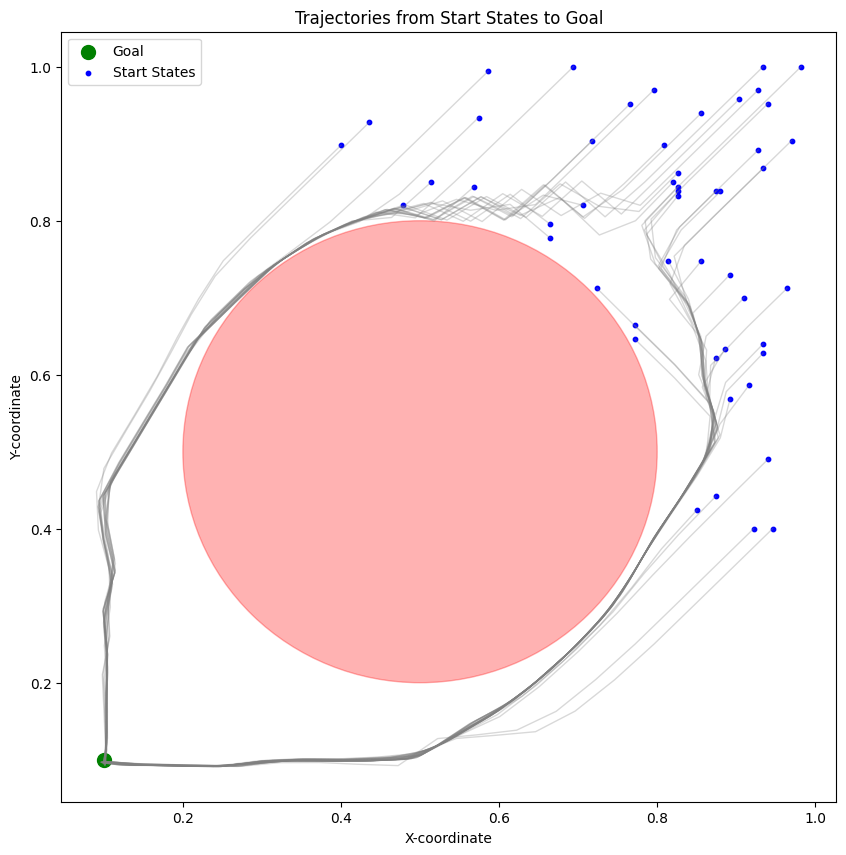

In [33]:
plot_trajectories(risky_policy)

In [18]:
get_returns(mixed_policy, 50, False, True)

(array([-17.69936595, -17.69936595, -17.69936595, -17.69936595,
        -37.69936595, -17.69936595, -17.69936595, -17.69936595,
        -37.69936595, -37.69936595, -17.69936595, -37.69936595,
        -17.69936595, -37.69936595, -17.69936595, -17.69936595,
        -17.69936595, -17.69936595, -17.69936595, -17.69936595,
        -17.69936595, -17.69936595, -17.69936595, -37.69936595,
        -37.69936595, -17.69936595, -37.69936595, -17.69936595,
        -17.69936595, -17.69936595, -17.69936595, -17.69936595,
        -17.69936595, -17.69936595, -17.69936595, -37.69936595,
        -17.69936595, -17.69936595, -17.69936595, -17.69936595,
        -17.69936595, -17.69936595, -17.69936595, -17.69936595,
        -17.69936595, -17.69936595, -17.69936595, -17.69936595,
        -17.69936595, -17.69936595]),
 0.0)

In [24]:
test_collector = Collector(risky_policy, test_envs, test_buffer)

In [26]:
test_collector.collect(n_episode=100)

{'n/ep': 100,
 'n/st': 1334,
 'rews': array([ -3.36564222,  -3.9210581 ,  -4.29827294,  -6.01332005,
         -5.13010286,   0.89090229,  -5.1491528 , -16.86204476,
         -7.98423838,  -8.33182337,  -8.55101418,  -1.87576188,
          0.10414351,  -0.55496206,  -5.06084959,  -6.51592333,
         -8.10115572, -18.83971209, -16.40116125,  -8.30147115,
          0.10985565, -27.56468591,  -7.54468675,  -8.09779909,
         -6.73911583, -15.48189416,  -2.56507107,  -6.63616988,
         -8.48987896, -18.52518402,  -1.57082081,  -2.37329512,
        -18.27827323,  -8.09738307,  -1.88838495,  -6.27214523,
         -6.17662617,  -5.85986661,   0.11851418,  -5.1881392 ,
          0.77050705, -17.12752378, -16.69805686, -17.72309734,
        -20.30142258, -17.21767428,   0.41371564, -29.64664598,
         -7.45480501,  -4.034515  ,  -6.78466337, -26.49158039,
         -5.34252157, -19.22717382,  -6.84092993, -27.44723822,
         -1.4045326 ,   0.56159345,  -3.13548983,  -6.68288145,
   